<a href="https://colab.research.google.com/github/ejk9658/ejk9658/blob/main/(%EC%B5%9C%EC%A2%85)%EC%86%8C%EC%8A%A4%EC%BD%94%EB%93%9C_%EC%9D%BC%EC%84%9D%EC%82%BC%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2020년 강원도 소방본부 구급 출동 AI 예측**

# 목차

### 0. 개요

### 1. Library & Data Import
> 사용할 Library
사용할 데이터셋
Feature Description
데이터셋 기본 정보 파악
종속 변수(목표 변수) 탐색

### 2. 데이터 전처리(1)
>'DSP_CNT_IDEX' 평균값(23.9) 이상의 상위 데이터만 split
유동인구 0(null)인 행 drop
날짜 변수의 파생변수 추가 - MONTH / DAY / WEEKDAY / HOLIDAY
기상청 API를 이용하여 기온, 강수량, 일교차 컬럼 추가
climate.csv 불러오기
'TEMPERATURES' 절댓값 처리
dataframe merge
원주시 코로나 확진자 데이터를 이용하여 일별 코로나 확진자 컬럼 추가


### 3. 데이터 이해를 위한 탐색과 시각화 (EDA)
>설명 변수 탐색
설명변수와 종속변수 간의 관계 탐색
2020년 구급활동 현황에 근거한 변수 간의 관계 탐색
지리적 데이터 시각화 (KATEC 격자 지도)

### 4. 데이터 전처리(2)
>EDA 분석을 토대로 각 격자를 설명할 수 있는 변수생성(1) - dwelling_index, road_index
EDA 분석을 토대로 각 격자를 설명할 수 있는 변수생성(2) - bar_cnt
분류 모델 만들기 위해 'DSP_CNT_IDEX' 1 이상이면 'target' 컬럼에 1을 할당, 0과 1 값의 비율 확인
여러 컬럼 Scaling
One_Hot Encoding() - WEEKDAY
Feature Description

### 5. 학습 데이터셋 및 머신러닝 예측 모델 생성
>Distributing - X, y split
Random Under-Sampling
Equally Distributing and Correlating
Classifiers (UnderSampling)
각 모델 하이퍼 파라미터 탐색 후 모델 적용
df를 이용하여 undersampling
cross_val_score는 테스트 폴드의 점수를 반환, cross_val_predict는 테스트 폴드에 대한 예측 된 y 값을 반환
A Deeper Look into Decision Tree Classifier
SMOTE Technique (Over-Sampling)
Test Data with DecisionTreeClassifier

### 6. 모델 예측 결과
>매달 말일의 데이터프레임 생성 - finally_df
모델 예측 결과

# 0. 개요

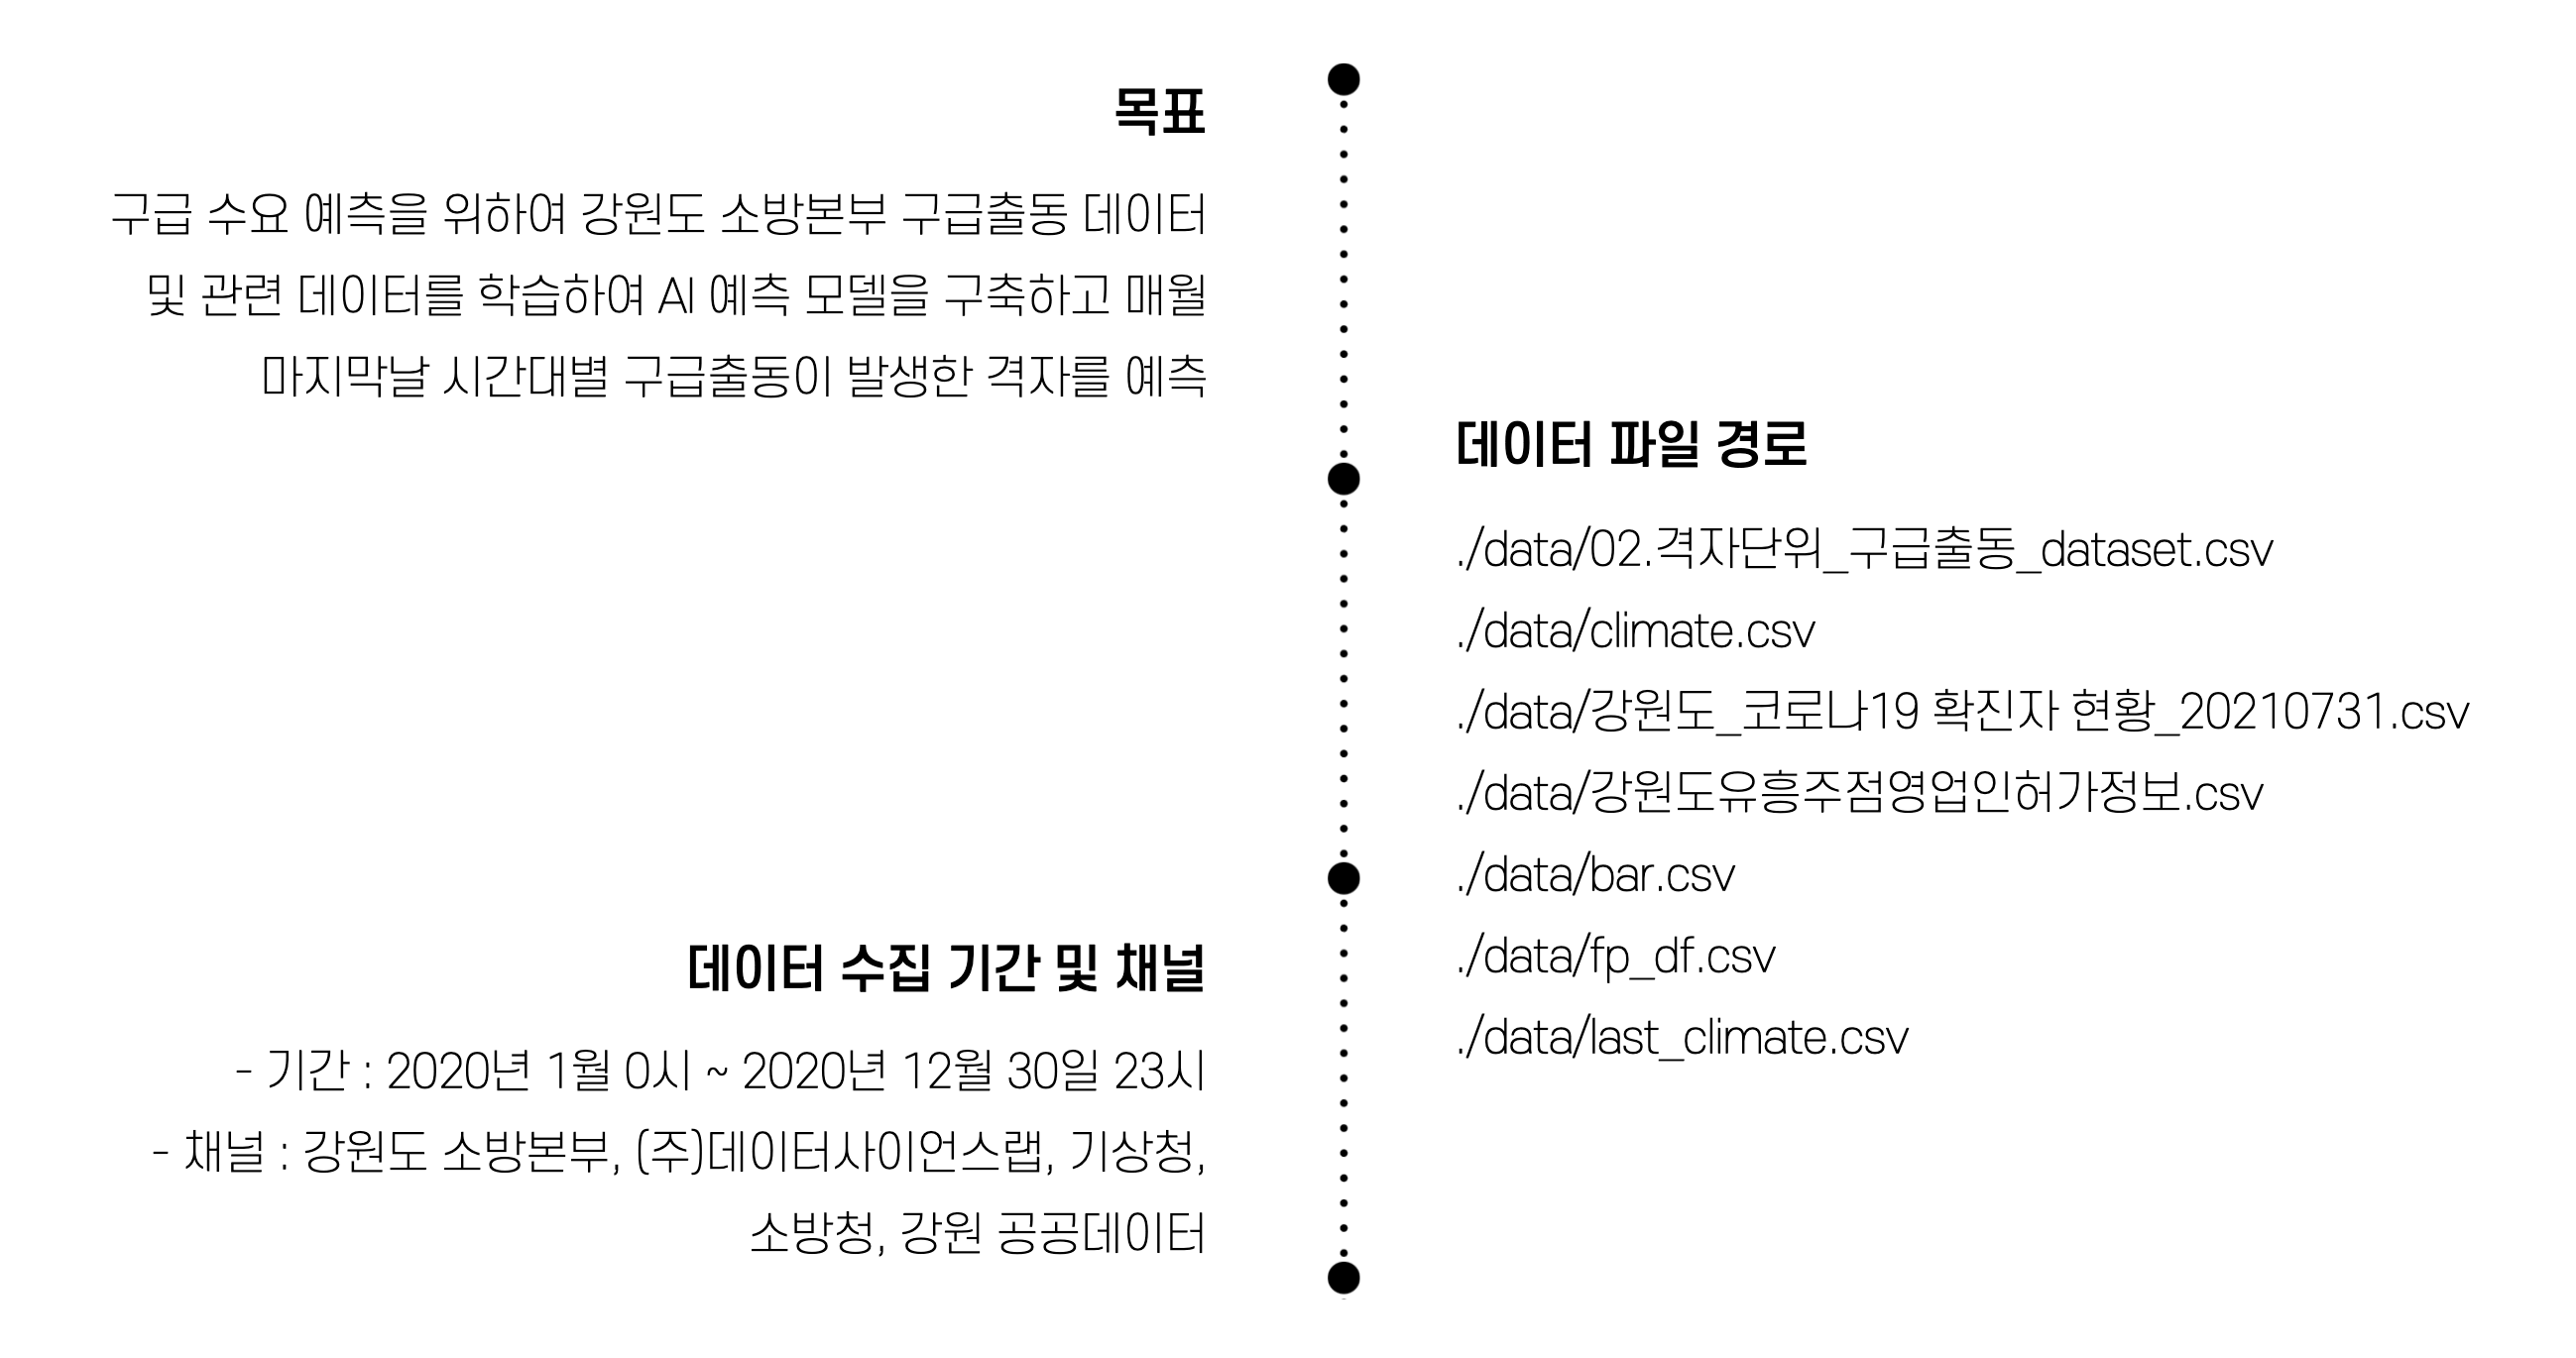

# 1. Library & Data Import

#### >> 사용할 Library

In [ ]:
# !pip install pyproj
# !pip install furl
# !pip install geopandas
# !pip install Rtree
# !pip install pygeos

In [ ]:
# 경고 무시 명령
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Image

## 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pandas.plotting import scatter_matrix

## 지도 시각화를 위한 라이브러리
from folium import plugins
from folium.features import DivIcon
import folium
import pyproj
from pyproj import Proj, transform
from shapely.geometry import Polygon
import geopandas as gpd

## 새로운 feature를 추가하기 위한 라이브러리
# 날짜
import time
import datetime
import holidays
# 날씨
import requests, bs4
from furl import furl
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 모델적용을 위한 전처리 라이브러리
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, \
GridSearchCV, cross_val_score, cross_val_predict, \
RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, \
StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.decomposition import PCA, TruncatedSVD
from collections import Counter
from sklearn.metrics import classification_report

# 분류 모델 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 모델 평가를 위한 라이브러리
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
confusion_matrix, roc_auc_score, f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, \
precision_recall_curve, confusion_matrix

# # row 생략 없이 출력
# pd.set_option('display.max_rows', None)
# # col 생략 없이 출력
pd.set_option('display.max_columns', None)
# # 옵션 초기화
# pd.reset_option('display.max_rows')

In [ ]:
# pd.options.display.float_format = '{:.5f}'.format    # 지수 e 표시 없애기
pd.reset_option('display.float_format')             # 지수 e 표시하기

#### >> 사용할 데이터셋 - '02.격자단위_구급출동_dataset.csv'

#### >> Feature Description

각 변수의 의미는 다음과 같습니다

0. GRID_ID : 격자 ID
1. GRID_X_AXIS : 격자 X축 좌표
2. GRID_Y_AXIS : 격자 Y축 좌표
3. TIME : 시간
4. YMD : 생성일자
5. STDG_CD : 법정동코드
6. FP_IDEX : 유동인구 지수
7. OLD_FP_IDEX : 노인 유동인구 지수
8. RELIFPLC_DWL_IDEX : 구급처_주거 지수
9. RELIFPLC_ROAD_IDEX : 구급처_도로(교통) 지수
10. RELIFPLC_INDUST_IDEX : 구급처_상업(산업) 지수
11. RELIFPLC_NTR_IDEX : 구급처_자연 지수
12. RELIFPLC_ETC_IDEX : 구급처_기타 지수
13. DSP_CNT_IDEX : 출동빈도 지수
14. DISEASE_DSP_IDEX : 질병출동 지수
15. DISEASE_EXCL_DSP_IDEX : 질병외출동 지수

In [ ]:
datadf = pd.read_csv("02.격자단위_구급출동_dataset.csv")
datadf

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,STDG_CD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX
0,38045314,380475,531475,0,20200101,4213000000,2.88,0.72,0,0,0,0,0,0,0,0
1,38045324,380475,532475,0,20200101,4213000000,9.36,1.44,0,0,0,0,0,0,0,0
2,38145354,381475,535475,0,20200101,4213000000,3.93,0.15,0,0,0,0,0,0,0,0
3,38245184,382475,518475,0,20200101,4213000000,2.69,0.16,0,0,0,0,0,0,0,0
4,38245194,382475,519475,0,20200101,4213000000,2.35,0.14,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769073,40245274,402475,527475,23,20201230,4213000000,25.48,1.04,0,0,0,0,0,0,0,0
1769074,40545364,405475,536475,23,20201230,4213000000,1.21,0.32,0,0,0,0,0,0,0,0
1769075,40645144,406475,514475,23,20201230,4213000000,1.28,0.30,0,0,0,0,0,0,0,0
1769076,40745144,407475,514475,23,20201230,4213000000,6.17,1.47,0,0,0,0,0,0,0,0


#### >> 데이터셋 기본 정보 파악

In [ ]:
datadf.shape

(1769078, 16)

In [ ]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769078 entries, 0 to 1769077
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   GRID_ID                int64  
 1   GRID_X_AXIS            int64  
 2   GRID_Y_AXIS            int64  
 3   TIME                   int64  
 4   YMD                    int64  
 5   STDG_CD                int64  
 6   FP_IDEX                float64
 7   OLD_FP_IDEX            float64
 8   RELIFPLC_DWL_IDEX      int64  
 9   RELIFPLC_ROAD_IDEX     int64  
 10  RELIFPLC_INDUST_IDEX   int64  
 11  RELIFPLC_NTR_IDEX      int64  
 12  RELIFPLC_ETC_IDEX      int64  
 13  DSP_CNT_IDEX           int64  
 14  DISEASE_DSP_IDEX       int64  
 15  DISEASE_EXCL_DSP_IDEX  int64  
dtypes: float64(2), int64(14)
memory usage: 216.0 MB


In [ ]:
datadf.isnull().sum()

GRID_ID                  0
GRID_X_AXIS              0
GRID_Y_AXIS              0
TIME                     0
YMD                      0
STDG_CD                  0
FP_IDEX                  0
OLD_FP_IDEX              0
RELIFPLC_DWL_IDEX        0
RELIFPLC_ROAD_IDEX       0
RELIFPLC_INDUST_IDEX     0
RELIFPLC_NTR_IDEX        0
RELIFPLC_ETC_IDEX        0
DSP_CNT_IDEX             0
DISEASE_DSP_IDEX         0
DISEASE_EXCL_DSP_IDEX    0
dtype: int64

In [ ]:
datadf.describe()

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,STDG_CD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX
count,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06,1.769078e+06
mean,3.926545e+07,3.926770e+05,5.258797e+05,1.280125e+01,2.020068e+07,4.213000e+09,4.101418e+02,3.944397e+01,4.950036e-03,1.821853e-03,5.449166e-04,1.938863e-04,7.088438e-04,9.312195e-03,4.077265e-03,5.234930e-03
std,6.272332e+05,6.272231e+03,7.287446e+03,6.259200e+00,3.409836e+02,0.000000e+00,9.845126e+02,1.065871e+02,7.344097e-02,4.905519e-02,2.384033e-02,1.448020e-02,2.761535e-02,1.072808e-01,6.489225e-02,8.125642e-02
min,3.764586e+07,3.764750e+05,5.044750e+05,0.000000e+00,2.020010e+07,4.213000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.884529e+07,3.884750e+05,5.224750e+05,8.000000e+00,2.020041e+07,4.213000e+09,5.100000e+00,5.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.934524e+07,3.934750e+05,5.264750e+05,1.300000e+01,2.020071e+07,4.213000e+09,2.954000e+01,2.780000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.964536e+07,3.964750e+05,5.314750e+05,1.800000e+01,2.020100e+07,4.213000e+09,2.589800e+02,2.021000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.994551e+07,4.994750e+05,5.864750e+05,2.300000e+01,2.020123e+07,4.213000e+09,1.065106e+04,1.888090e+03,1.100000e+01,1.000000e+01,2.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,7.000000e+00,1.100000e+01


In [ ]:
# 모든 row에 같은 값이 들어있는 'STDG_CD' 컬럼 drop
datadf.drop(['STDG_CD'], axis=1, inplace=True)

#### >> 종속 변수(목표 변수) 탐색

In [ ]:
datadf['DSP_CNT_IDEX'].describe()

count    1.769078e+06
mean     9.312195e-03
std      1.072808e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: DSP_CNT_IDEX, dtype: float64

<AxesSubplot:>

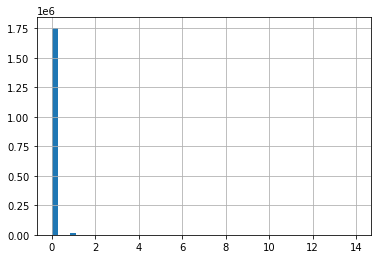

In [ ]:
# histogram
datadf['DSP_CNT_IDEX'].hist(bins=50)

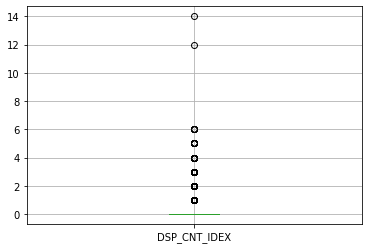

In [ ]:
# boxplot
datadf.boxplot(column=['DSP_CNT_IDEX'])
plt.show()

In [ ]:
datadf['DSP_CNT_IDEX'].value_counts()

0     1754189
1       13542
2        1187
3         122
4          20
5          10
6           6
12          1
14          1
Name: DSP_CNT_IDEX, dtype: int64

# 2. 데이터 전처리(1)

#### >> 'DSP_CNT_IDEX' 평균값(23.9) 이상의 상위 데이터만 split

**class 값이 지나치게 한쪽으로 치우쳐져 있어 일년에 평균(24)이하로 출동하는 격자지역은 모델적용에 있어서 유의미하지 않을 것으로 생각함**

In [ ]:
# GRID_ID별 DSP_CNT_IDEX 내림차순 정렬
dsp_df = datadf[['GRID_ID','DSP_CNT_IDEX']].groupby('GRID_ID').sum().sort_values(by='DSP_CNT_IDEX', ascending=False)
dsp_df

,DSP_CNT_IDEX
GRID_ID,
39545254,1085
39545274,961
39445274,708
39645264,608
39645244,511
...,...
39145104,0
38645304,0
38645314,0


In [ ]:
dsp_df.describe()

,DSP_CNT_IDEX
count,687.000000
mean,23.979622
std,88.925590
min,0.000000
25%,1.000000
50%,4.000000
75%,11.000000
max,1085.000000


In [ ]:
# 1년동안 24번(각 아이디DSP_CNT_IDEX의 평균값) 이상 출동한 격자id 추출
dsp_df[dsp_df['DSP_CNT_IDEX']>23].index

Int64Index([39545254, 39545274, 39445274, 39645264, 39645244, 39545264,
            39445264, 39545244, 39645274, 39445284, 39445294, 39545284,
            39645254, 39645284, 39345264, 39345274, 39745264, 39345254,
            39445254, 39545314, 39645314, 39545304, 39445244, 39745244,
            39645234, 39345284, 38445234, 38545244, 39745234, 39745254,
            39445304, 39645344, 39845244, 38345224, 39645304, 39545334,
            39345224, 40745144, 39245214, 38945304, 39845264, 39945254,
            39445324, 39245194, 39645294, 38445244, 39545324, 39945264,
            39845224, 39245284, 38545254, 39145284, 39245264, 39345234,
            39645334, 39045254, 39745274, 39545294, 38645324, 40145264,
            39345244, 38945074, 38845304, 39245204, 39745314, 40045264,
            39645324, 38445224, 38445254, 38645244, 39145194, 40045254,
            39145274, 38545294, 39245224, 39945214],
           dtype='int64', name='GRID_ID')

In [ ]:
# GRID_ID별 DSP_CNT_IDEX총합의 평균값(23.979622) 이상인 GRID_ID만 추출하여 새로운 df 생성
df = datadf.loc[datadf['GRID_ID'].isin(dsp_df[dsp_df['DSP_CNT_IDEX']>23].index)]
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX
12,38345224,383475,522475,0,20200101,4.18,0.34,0,0,0,0,0,0,0,0
18,38445224,384475,522475,0,20200101,13.19,1.65,0,0,0,0,0,0,0,0
19,38445234,384475,523475,0,20200101,340.74,28.71,0,0,0,0,0,0,0,0
20,38445244,384475,524475,0,20200101,156.82,9.65,0,0,0,0,0,0,0,0
21,38445254,384475,525475,0,20200101,16.81,1.25,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769057,39945254,399475,525475,23,20201230,1415.55,84.09,0,0,0,0,0,0,0,0
1769058,39945264,399475,526475,23,20201230,655.22,69.77,0,0,0,0,0,0,0,0
1769063,40045254,400475,525475,23,20201230,1473.28,101.68,0,0,0,0,0,0,0,0
1769064,40045264,400475,526475,23,20201230,824.52,57.97,0,0,0,0,0,0,0,0


In [ ]:
df['DSP_CNT_IDEX'].value_counts()

0     594956
1      11018
2       1005
3         95
4         17
5          7
6          5
14         1
Name: DSP_CNT_IDEX, dtype: int64

#### >> 유동인구 0(null)인 행 drop

In [ ]:
# 유동인구 0 (null) 인 행 인덱스 추출
fpnull_idex= df[df['FP_IDEX']==0].index
fpnull_idex

Int64Index([    676,   14650,   18404,   37843,   66756,   70337,   75422,
              89998,  102209,  136590,  177127,  209949,  210144,  213837,
             227993,  236181,  236477,  236591,  257907,  339206,  347302,
             347688,  352462,  405302,  419178,  422532,  451066,  494715,
             499360,  552736,  552885,  588283,  597801,  598574,  599526,
             627214,  642259,  661672,  666955,  682421,  733112,  763650,
             774165,  780003,  789405,  800229,  812984,  838477,  881548,
             912351,  923454,  927064, 1001812, 1008307, 1029248, 1034156,
            1054203, 1075103, 1093244, 1097693, 1149228, 1164199, 1195632,
            1207736, 1241287, 1246245, 1260724, 1271894, 1276418, 1277450,
            1277684, 1290683, 1292722, 1352734, 1411792, 1491939, 1531811,
            1542053, 1550027, 1563402, 1564148, 1584120, 1586518, 1599402,
            1602886, 1638898, 1651814, 1686173, 1698275, 1717503, 1736942,
            1740671, 1751

In [ ]:
# 유동인구 0 (null) 인 행 drop
df = df.drop(index = fpnull_idex)
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX
12,38345224,383475,522475,0,20200101,4.18,0.34,0,0,0,0,0,0,0,0
18,38445224,384475,522475,0,20200101,13.19,1.65,0,0,0,0,0,0,0,0
19,38445234,384475,523475,0,20200101,340.74,28.71,0,0,0,0,0,0,0,0
20,38445244,384475,524475,0,20200101,156.82,9.65,0,0,0,0,0,0,0,0
21,38445254,384475,525475,0,20200101,16.81,1.25,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769057,39945254,399475,525475,23,20201230,1415.55,84.09,0,0,0,0,0,0,0,0
1769058,39945264,399475,526475,23,20201230,655.22,69.77,0,0,0,0,0,0,0,0
1769063,40045254,400475,525475,23,20201230,1473.28,101.68,0,0,0,0,0,0,0,0
1769064,40045264,400475,526475,23,20201230,824.52,57.97,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607010 entries, 12 to 1769076
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   GRID_ID                607010 non-null  int64  
 1   GRID_X_AXIS            607010 non-null  int64  
 2   GRID_Y_AXIS            607010 non-null  int64  
 3   TIME                   607010 non-null  int64  
 4   YMD                    607010 non-null  int64  
 5   FP_IDEX                607010 non-null  float64
 6   OLD_FP_IDEX            607010 non-null  float64
 7   RELIFPLC_DWL_IDEX      607010 non-null  int64  
 8   RELIFPLC_ROAD_IDEX     607010 non-null  int64  
 9   RELIFPLC_INDUST_IDEX   607010 non-null  int64  
 10  RELIFPLC_NTR_IDEX      607010 non-null  int64  
 11  RELIFPLC_ETC_IDEX      607010 non-null  int64  
 12  DSP_CNT_IDEX           607010 non-null  int64  
 13  DISEASE_DSP_IDEX       607010 non-null  int64  
 14  DISEASE_EXCL_DSP_IDEX  607010 non-

#### >> 날짜 변수의 파생변수 추가 - MONTH / DAY / WEEKDAY / HOLIDAY

In [ ]:
# 타입 변환 함수 (int,object to datetime)
def toDatetime(i_ymd):
    i_ymd = i_ymd.astype('str')
    return pd.to_datetime(i_ymd)

# 타입 변환 함수 (datetime to object)
def to_object(dt_ymd):
    return dt_ymd.astype('str')

# 타입 변환 함수 (datetime to int)
def to_integer(dt_ymd):
    try:
        return 10000*dt_ymd.dt.year + 100*dt_ymd.dt.month + dt_ymd.dt.day
    except:
        return dt_ymd

# 타입 변환 함수 (object to int)
def to_int(ob_ymd):
    ob_ymd.replace('-','')
    ob_ymd = pd.to_datetime(ob_ymd)
    try:
        return 10000*ob_ymd.dt.year + 100*ob_ymd.dt.month + ob_ymd.dt.day
    except:
        return ob_ymd

In [ ]:
# 'YMD' 컬럼 타입 변환 (int to datetime)
df['YMD'] = toDatetime(df['YMD'])

# 'MONTH', 'DAY', 'WEEKDAY' 컬럼 추가
df['MONTH'] = df['YMD'].dt.month
df['DAY'] = df['YMD'].dt.day
df['WEEKDAY'] = df['YMD'].dt.weekday    # 월요일 0 ~ 일요일 6 (int형)

# holidays 데이터 가져오기
holiday_list=df.YMD
kr_holidays = holidays.KR()

# HOLIDAY는 1 NON_HOLIDAY는 0으로 표시
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(holiday_list)
holiday_df = holiday_df.drop_duplicates()
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
holiday_df.rename(columns = {'ds' : 'YMD'}, inplace=True)
df = pd.merge(df, holiday_df, on=['YMD'], how='left')
df.rename(columns = {'holiday' : 'HOLIDAY'}, inplace=True)

# 'YMD' 컬럼 타입 변환 (datetime to object)
df['YMD'] = to_object(df['YMD'])

In [ ]:
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1
1,38445224,384475,522475,0,2020-01-01,13.19,1.65,0,0,0,0,0,0,0,0,1,1,2,1
2,38445234,384475,523475,0,2020-01-01,340.74,28.71,0,0,0,0,0,0,0,0,1,1,2,1
3,38445244,384475,524475,0,2020-01-01,156.82,9.65,0,0,0,0,0,0,0,0,1,1,2,1
4,38445254,384475,525475,0,2020-01-01,16.81,1.25,0,0,0,0,0,0,0,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,39945254,399475,525475,23,2020-12-30,1415.55,84.09,0,0,0,0,0,0,0,0,12,30,2,0
607006,39945264,399475,526475,23,2020-12-30,655.22,69.77,0,0,0,0,0,0,0,0,12,30,2,0
607007,40045254,400475,525475,23,2020-12-30,1473.28,101.68,0,0,0,0,0,0,0,0,12,30,2,0
607008,40045264,400475,526475,23,2020-12-30,824.52,57.97,0,0,0,0,0,0,0,0,12,30,2,0


In [ ]:
df.isnull().sum()

GRID_ID                  0
GRID_X_AXIS              0
GRID_Y_AXIS              0
TIME                     0
YMD                      0
FP_IDEX                  0
OLD_FP_IDEX              0
RELIFPLC_DWL_IDEX        0
RELIFPLC_ROAD_IDEX       0
RELIFPLC_INDUST_IDEX     0
RELIFPLC_NTR_IDEX        0
RELIFPLC_ETC_IDEX        0
DSP_CNT_IDEX             0
DISEASE_DSP_IDEX         0
DISEASE_EXCL_DSP_IDEX    0
MONTH                    0
DAY                      0
WEEKDAY                  0
HOLIDAY                  0
dtype: int64

#### >> 기상청 API를 이용하여 기온, 강수량, 일교차 컬럼 추가

**키 값 문제로 csv 파일로 미리 저장함**

In [ ]:
# """
# 'YMD': 'dt',
# 'TIME': 'Hour',
# 'TEMPERATURES': 'ta',
# 'PRECIPITATION': 'rn'
# """

# # 기후 데이터 가져오는 함수
# def get_api(url, climate):
#     request = requests.get(url=url).text.encode('utf-8')
#     xmlobj = bs4.BeautifulSoup(request, 'html.parser')
#     rows = xmlobj.findAll('item')
#     for i, row in enumerate(rows):
#         climate.loc[len(climate)] = [
#             row.tm.string.split(" ")[0],
#             row.tm.string.split(" ")[1],
#             row.ta.string,
#             row.rn.string,]
#     return rows

# # 기후 데이터프레임 만드는 함수
# def df_climate(df):
#     climate = pd.DataFrame(columns=('YMD','TIME','TEMPERATURES','PRECIPITATION'))

#     for dt in df['YMD'].unique():
#         url = furl('http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList')
#         url.args['serviceKey'] =  SERVICEKEY
#         url.args['numOfRows'] = '30'
#         url.args['pageNo'] = '1'
#         url.args['dataCd'] = 'ASOS'
#         url.args['dateCd'] = 'HR'
#         url.args['stnIds'] = '114'
#         url.args['startDt'] = dt.replace('-','')
#         url.args['startHh'] = '00'
#         url.args['endDt'] = dt.replace('-','')
#         url.args['endHh'] = '23'
#         rows = get_api(url.url, climate)

#     return climate

In [ ]:
# climate = df_climate(df)

# # 'TIME'컬럼 타입 변환 (object to int)
# for i in climate.index:
#     climate['TIME'][i] = int(climate['TIME'][i][:2])
# climate['TIME'] = climate['TIME'].astype('int')

# climate

**nan값 처리**

In [ ]:
# # climate의 nan 값 확인하기
# climate.isna().sum()

In [ ]:
# # 'TEMPERATURES'의 nan 처리 : 이전 시간의 'TEMPERATURES' 데이터로 채우기
# climate['TEMPERATURES'].fillna(method='bfill', inplace=True)

# # 'PRECIPITATION'의 nan 처리 : 0 으로 채우기
# climate['PRECIPITATION'].fillna(0, inplace=True)

# climate.isna().sum()

**형변환 (object to float)**

In [ ]:
# climate.info()

In [ ]:
# climate['TEMPERATURES'] = climate['TEMPERATURES'].astype('float')
# climate['PRECIPITATION'] = climate['PRECIPITATION'].astype('float')

In [ ]:
# climate.info()

In [ ]:
# climate

**일교차 컬럼 추가**

In [ ]:
# ## 일교차 컬럼 추가
# for i in climate['YMD'].unique():
#     climate.loc[climate['YMD'] == i, 'TEMP_DIFF'] = float(climate[climate['YMD'] == i].TEMPERATURES.max()) - float(climate[climate['YMD'] == i].TEMPERATURES.min())

# climate

**'climate.csv' 저장**

In [ ]:
# climate.to_csv('./data/climate.csv', index=False, encoding='cp949')

#### >> climate.csv 불러오기

In [ ]:
climate = pd.read_csv("./data/climate.csv")
climate

,YMD,TIME,TEMPERATURES,PRECIPITATION,TEMP_DIFF
0,2020-01-01,0,-6.9,0.0,7.2
1,2020-01-01,1,-6.6,0.0,7.2
2,2020-01-01,2,-6.1,0.0,7.2
3,2020-01-01,3,-6.7,0.0,7.2
4,2020-01-01,4,-6.4,0.0,7.2
...,...,...,...,...,...
8491,2020-12-30,19,-9.0,0.0,8.9
8492,2020-12-30,20,-9.5,0.0,8.9
8493,2020-12-30,21,-10.0,0.0,8.9
8494,2020-12-30,22,-10.5,0.0,8.9


#### >> 'TEMPERATURES' 절댓값 처리

In [ ]:
# 덥거나 추운 날씨에 가중치를 주기위해 온화한온도 18도를 기준으로 절댓값처리
climate['scaled_TEMPERATURES'] = np.where(climate['TEMPERATURES'] >= 18,
                                   climate['TEMPERATURES'] - 18,
                                   18 - climate['TEMPERATURES'])
climate

,YMD,TIME,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES
0,2020-01-01,0,-6.9,0.0,7.2,24.9
1,2020-01-01,1,-6.6,0.0,7.2,24.6
2,2020-01-01,2,-6.1,0.0,7.2,24.1
3,2020-01-01,3,-6.7,0.0,7.2,24.7
4,2020-01-01,4,-6.4,0.0,7.2,24.4
...,...,...,...,...,...,...
8491,2020-12-30,19,-9.0,0.0,8.9,27.0
8492,2020-12-30,20,-9.5,0.0,8.9,27.5
8493,2020-12-30,21,-10.0,0.0,8.9,28.0
8494,2020-12-30,22,-10.5,0.0,8.9,28.5


#### >> dataframe merge

In [ ]:
df = pd.merge(df, climate, on=['YMD','TIME'])

In [ ]:
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9
1,38445224,384475,522475,0,2020-01-01,13.19,1.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9
2,38445234,384475,523475,0,2020-01-01,340.74,28.71,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9
3,38445244,384475,524475,0,2020-01-01,156.82,9.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9
4,38445254,384475,525475,0,2020-01-01,16.81,1.25,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,39945254,399475,525475,23,2020-12-30,1415.55,84.09,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2
607006,39945264,399475,526475,23,2020-12-30,655.22,69.77,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2
607007,40045254,400475,525475,23,2020-12-30,1473.28,101.68,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2
607008,40045264,400475,526475,23,2020-12-30,824.52,57.97,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2


#### >> 원주시 코로나 확진자 데이터를 이용하여 일별 코로나 확진자 컬럼 추가

**가설 : 작년 코로나 발생으로 인해 확진자 발생 시 구급 출동 횟수에 영향을 미쳤을 것이다.**

In [ ]:
# 데이터 불러오기
corona = pd.read_csv("./data/강원도_코로나19 확진자 현황_20210731.csv", encoding='cp949')
corona

,시군명,확진시기,확진자수
0,춘천,2020-02-22,2
1,원주,2020-02-22,0
2,강릉,2020-02-22,0
3,동해,2020-02-22,0
4,태백,2020-02-22,0
...,...,...,...
9463,화천,2021-07-31,0
9464,양구,2021-07-31,0
9465,인제,2021-07-31,0
9466,고성,2021-07-31,1


In [ ]:
# 강원도 코로나 정보 중 원주시에 해당하는 데이터만 slicing
corona = corona.loc[(corona['시군명']=='원주'),:]
corona

,시군명,확진시기,확진자수
1,원주,2020-02-22,0
19,원주,2020-02-23,0
37,원주,2020-02-24,0
55,원주,2020-02-25,0
73,원주,2020-02-26,0
...,...,...,...
9379,원주,2021-07-27,37
9397,원주,2021-07-28,8
9415,원주,2021-07-29,2
9433,원주,2021-07-30,5


In [ ]:
# 기존 데이터와 merge하기 위해 column name을 같은 이름으로 변경해주고 필요한 columns만 slicing
corona.rename(columns = {'확진시기' : 'YMD','확진자수':'covid_19'}, inplace=True)
corona = corona[['YMD','covid_19']]
corona

,YMD,covid_19
1,2020-02-22,0
19,2020-02-23,0
37,2020-02-24,0
55,2020-02-25,0
73,2020-02-26,0
...,...,...
9379,2021-07-27,37
9397,2021-07-28,8
9415,2021-07-29,2
9433,2021-07-30,5


In [ ]:
# 기존 데이터에 merge
df = pd.merge(df, corona, on=['YMD'], how='left')
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,NaN
1,38445224,384475,522475,0,2020-01-01,13.19,1.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,NaN
2,38445234,384475,523475,0,2020-01-01,340.74,28.71,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,NaN
3,38445244,384475,524475,0,2020-01-01,156.82,9.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,NaN
4,38445254,384475,525475,0,2020-01-01,16.81,1.25,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,39945254,399475,525475,23,2020-12-30,1415.55,84.09,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607006,39945264,399475,526475,23,2020-12-30,655.22,69.77,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607007,40045254,400475,525475,23,2020-12-30,1473.28,101.68,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607008,40045264,400475,526475,23,2020-12-30,824.52,57.97,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0


In [ ]:
# 작년 2월 이전 코로나 환자 없을 때의 null값 0으로 채우기
df = df.fillna({'covid_19':0})
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0
1,38445224,384475,522475,0,2020-01-01,13.19,1.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0
2,38445234,384475,523475,0,2020-01-01,340.74,28.71,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0
3,38445244,384475,524475,0,2020-01-01,156.82,9.65,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0
4,38445254,384475,525475,0,2020-01-01,16.81,1.25,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,39945254,399475,525475,23,2020-12-30,1415.55,84.09,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607006,39945264,399475,526475,23,2020-12-30,655.22,69.77,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607007,40045254,400475,525475,23,2020-12-30,1473.28,101.68,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0
607008,40045264,400475,526475,23,2020-12-30,824.52,57.97,0,0,0,0,0,0,0,0,12,30,2,0,-11.2,0.0,8.9,29.2,13.0


In [ ]:
backup1 = df.copy()

# 3. 데이터 이해를 위한 탐색과 시각화 (EDA)

#### >> 설명 변수 탐색

<AxesSubplot:xlabel='HOLIDAY', ylabel='DSP_CNT_IDEX'>

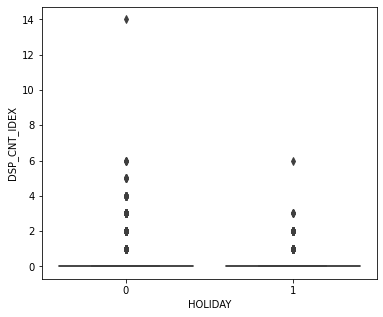

In [ ]:
# 공휴일 유무에 따른 구급출동 빈도수 확인
plt.figure(figsize=(6,5))
sns.boxplot(data=df,y="DSP_CNT_IDEX",x="HOLIDAY",orient="v")

In [ ]:
df[df['HOLIDAY']==1].YMD.unique()

array(['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26',
       '2020-01-27', '2020-03-01', '2020-05-01', '2020-05-05',
       '2020-06-06', '2020-08-15', '2020-08-17', '2020-10-01',
       '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25'],
      dtype=object)

In [ ]:
# df의 통계량 요약
df.describe()

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19
count,6.070100e+05,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000,607010.000000
mean,3.941040e+07,394126.356650,526315.022405,11.836014,1083.845631,107.591723,0.012067,0.004245,0.001262,0.000142,0.001726,0.021988,0.009916,0.012072,6.530303,15.273806,3.008616,0.045622,12.952901,0.151989,9.128382,9.335884,0.891206
std,4.333733e+05,4333.668729,4194.407620,6.824486,1440.433329,160.950259,0.114878,0.072630,0.036372,0.012575,0.043150,0.163655,0.101222,0.121816,3.446920,8.528708,1.998722,0.208664,10.138328,1.127061,3.268269,6.410934,2.304365
min,3.834522e+07,383475.000000,507475.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-14.400000,0.000000,1.800000,0.000000,0.000000
25%,3.924522e+07,392475.000000,524475.000000,6.000000,125.650000,11.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,1.000000,0.000000,4.500000,0.000000,6.700000,4.200000,0.000000
50%,3.954524e+07,395475.000000,526475.000000,12.000000,496.270000,45.635000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,15.000000,3.000000,0.000000,13.400000,0.000000,9.100000,8.200000,0.000000
75%,3.964531e+07,396475.000000,528475.000000,18.000000,1418.830000,133.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,23.000000,5.000000,0.000000,22.000000,0.000000,11.400000,13.700000,1.000000
max,4.074514e+07,407475.000000,534475.000000,23.000000,10651.060000,1888.090000,11.000000,6.000000,2.000000,3.000000,3.000000,14.000000,7.000000,7.000000,12.000000,30.000000,6.000000,1.000000,34.000000,32.100000,17.500000,32.400000,17.000000


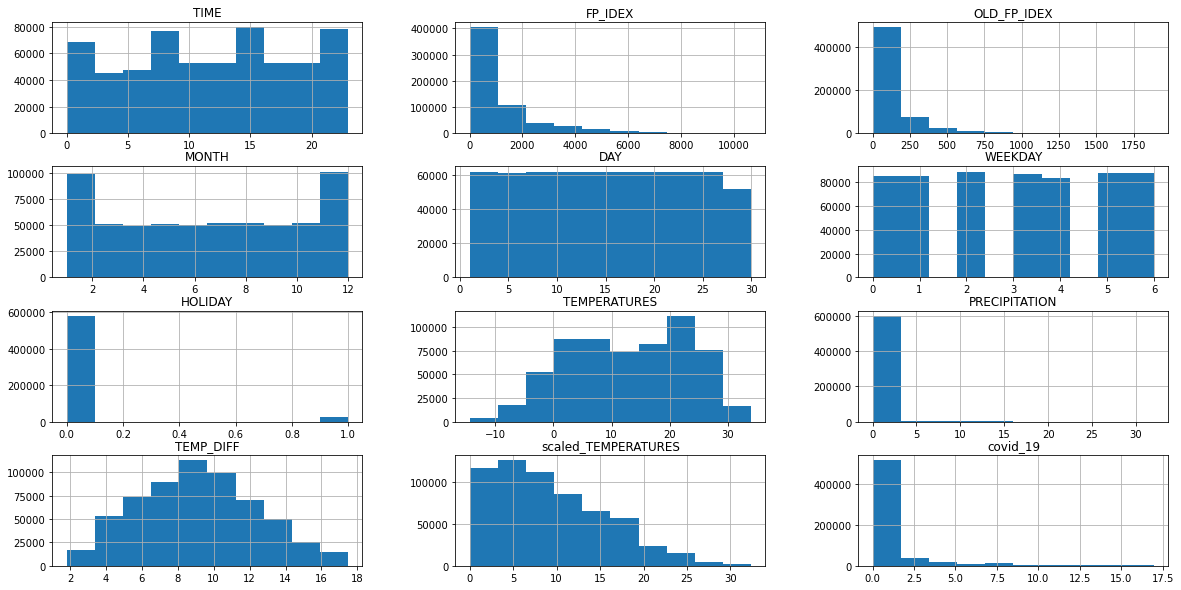

In [ ]:
numerical_columns = ['TIME', 'FP_IDEX', 'OLD_FP_IDEX','MONTH', 'DAY', 'WEEKDAY',\
                      'HOLIDAY', 'TEMPERATURES', 'PRECIPITATION', 'TEMP_DIFF','scaled_TEMPERATURES', 'covid_19' ]

fig = plt.figure(figsize = (20, 10))
ax = fig.gca()  # Axes 생성

df[numerical_columns].hist(ax=ax)
plt.show()

#### >> 설명변수와 종속변수 간의 관계 탐색

[Text(0.5, 0, 'TIME'), Text(0.5, 1.0, 'dispatch count by time')]

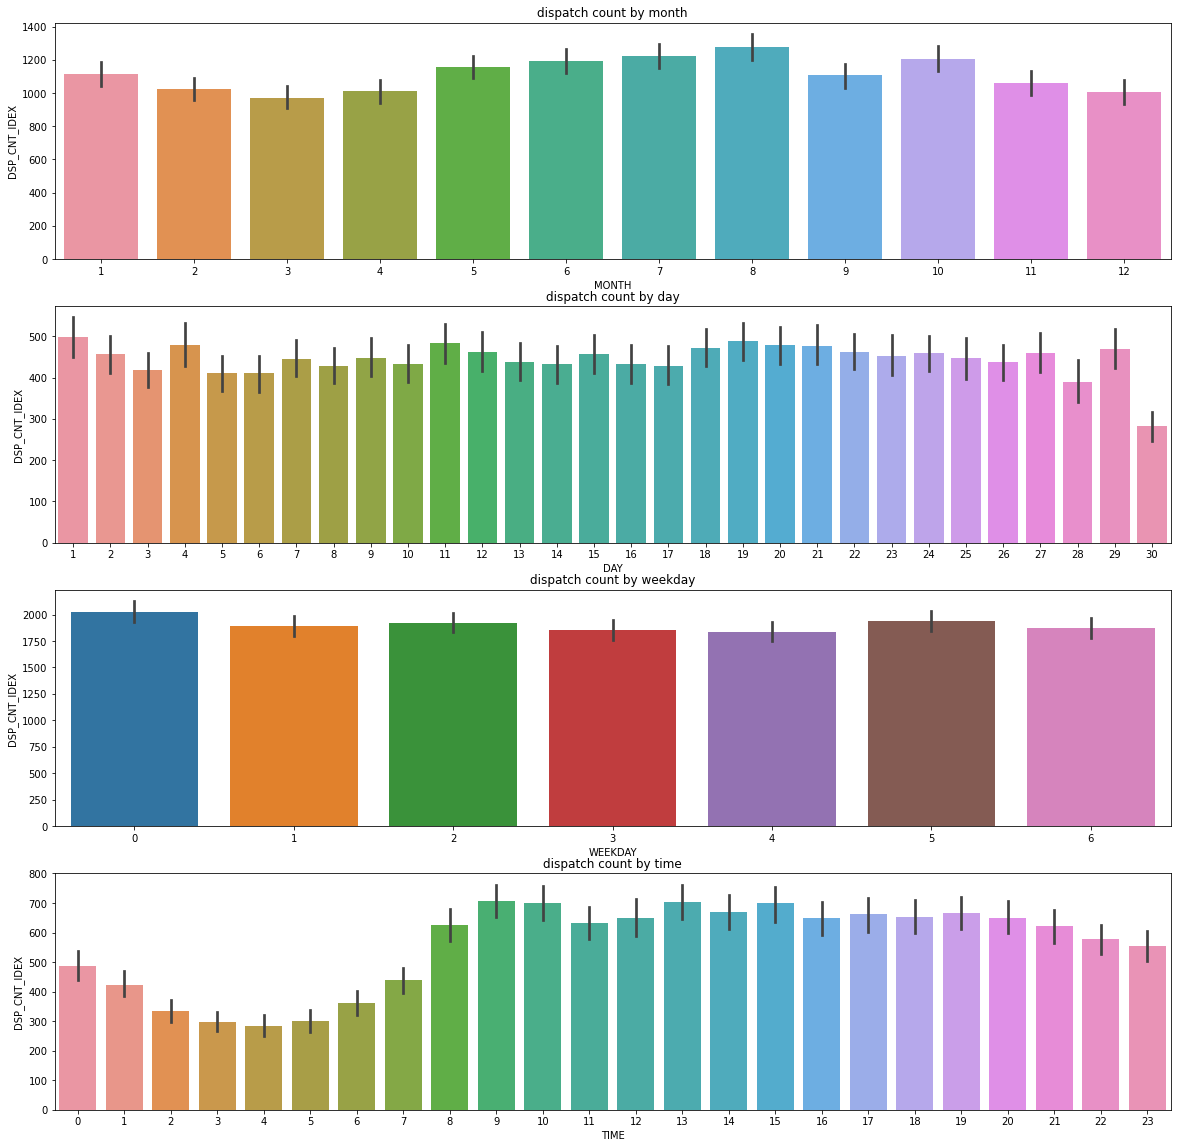

In [ ]:
# 월, 일, 요일, 시간에 따른 구급출동 빈도 시각화
figure, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1)
figure.set_size_inches(20,20)
sns.barplot(data=df, x="MONTH", y="DSP_CNT_IDEX", estimator=np.sum, ax=ax1)
sns.barplot(data=df, x="DAY", y="DSP_CNT_IDEX", estimator=np.sum, ax=ax2)
sns.barplot(data=df, x="WEEKDAY", y="DSP_CNT_IDEX", estimator=np.sum, ax=ax3)
sns.barplot(data=df, x="TIME", y="DSP_CNT_IDEX", estimator=np.sum, ax=ax4)

ax1.set(xlabel='MONTH',title="dispatch count by month")
ax2.set(xlabel='DAY',title="dispatch count by day")
ax3.set(xlabel='WEEKDAY',title="dispatch count by weekday")
ax4.set(xlabel='TIME', title="dispatch count by time")

In [ ]:
def heatmap(values, index, columns, aggfunc):
    c = df.pivot_table(values=values, index=index, columns=columns, aggfunc=aggfunc)
    ax = plt.subplots(figsize=(12, 6))
    ax = sns.heatmap(data=c, cmap='Reds')
    plt.title(f"{values} heatmap__{columns} by {index}")

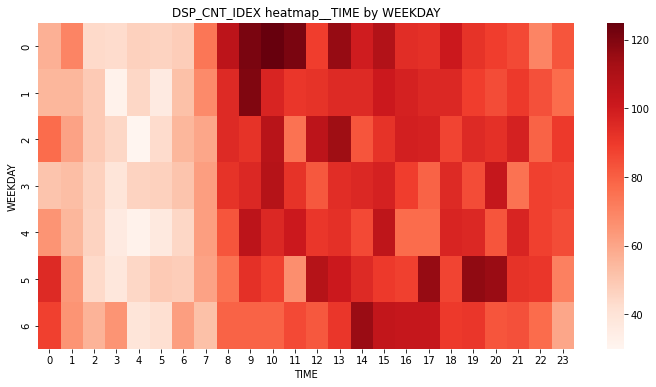

In [ ]:
heatmap('DSP_CNT_IDEX','WEEKDAY','TIME',sum)

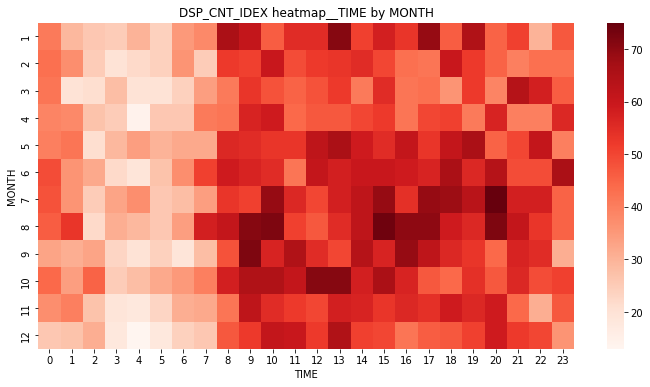

In [ ]:
heatmap('DSP_CNT_IDEX', 'MONTH', 'TIME', sum)

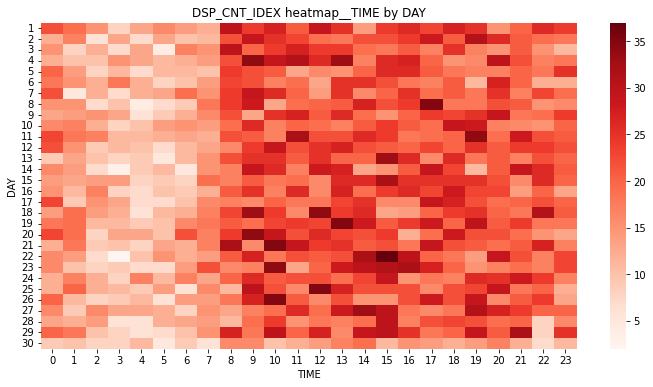

In [ ]:
heatmap('DSP_CNT_IDEX', 'DAY', 'TIME', sum)

#### >> 2020년 구급활동 현황에 근거한 변수 간의 관계 탐색

##### (출처: 소방청 2021년 119구급서비스 통계연보)

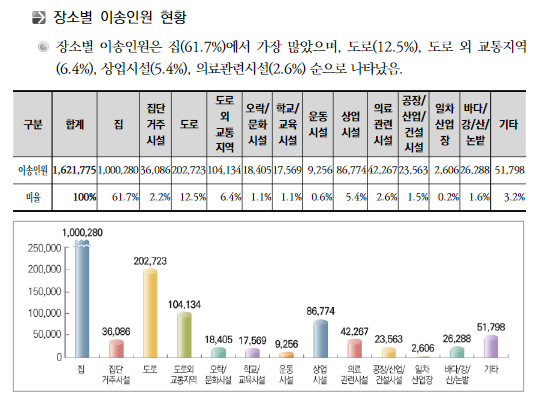

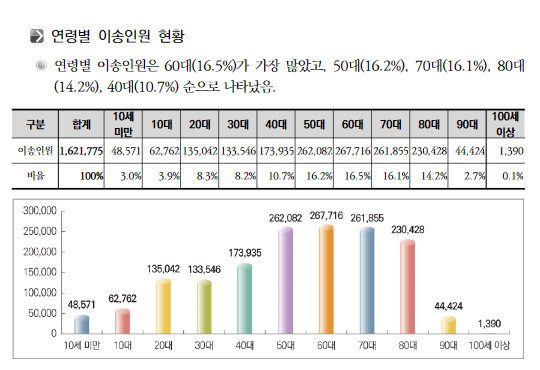

[Text(0.5, 1.0, 'Dwelling dispatch count by time')]

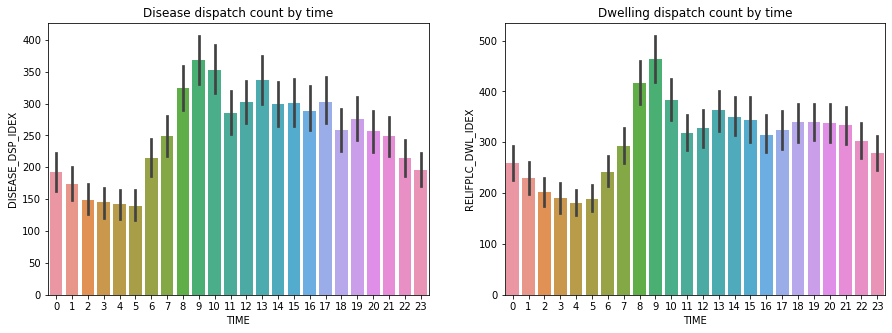

In [ ]:
# 시간대별 질병으로 인한 출동그래프와 시간대별 주거지역 출동 그래프
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.barplot(data=df, x="TIME", y="DISEASE_DSP_IDEX", estimator = np.sum, ax=ax1)
sns.barplot(data=df, x="TIME", y="RELIFPLC_DWL_IDEX", estimator = np.sum, ax=ax2)

ax1.set(title="Disease dispatch count by time")
ax2.set(title="Dwelling dispatch count by time")

**두 그래프의 추이 비슷  -> 주거지에서 질병 출동이 대다수임을 예상**

[Text(0.5, 1.0, 'Road dispatch count by time')]

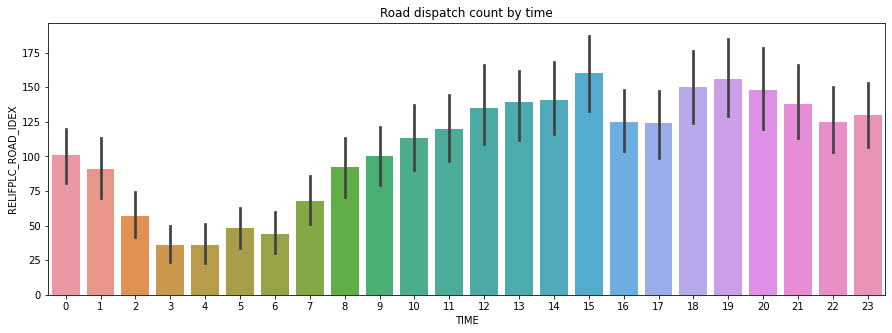

In [ ]:
1# 시간대별 도로 및 교통지역 출동 그래프
plt.figure(figsize = (15,5))
road_plot = sns.barplot(data=df, x="TIME", y="RELIFPLC_ROAD_IDEX", estimator = np.sum)
road_plot.set(title = "Road dispatch count by time")

[Text(0.5, 1.0, 'Industry dispatch count by time')]

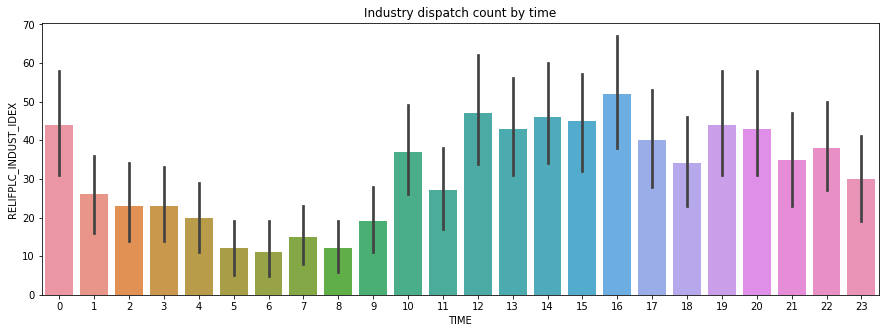

In [ ]:
# 시간대별 상업관련시설의 출동 횟수
plt.figure(figsize = (15,5))
industry_plot = sns.barplot(data=df, x="TIME", y="RELIFPLC_INDUST_IDEX", estimator = np.sum)
industry_plot.set(title = "Industry dispatch count by time")

**0시에 출동건수가 늘어남 -> 유흥가로 예측**

#### >> 지리적 데이터 시각화 (KATEC 격자 지도)

In [ ]:
def katec_to_wgs84(x, y):
    inProj  = Proj('+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43')
    outProj = Proj({ 'proj':'latlong', 'datum':'WGS84', 'ellps':'WGS84' })
    return transform( inProj, outProj, x, y )

In [ ]:
def date_color(x):
    if x > 4:
        a = '#FF4F00'
    elif x > 2:
        a = '#FCB100'
    elif x > 1:
        a = '#E0F500'
    elif x > 0:
        a = '#8CF700'
    else:
        a = '#00F000'
    return a

def time_color(x):
    if x > 20:
        a = '#FF4F00'
    elif x > 8:
        a = '#FCB100'
    elif x > 1:
        a = '#E0F500'
    elif x > 0:
        a = '#8CF700'
    else:
        a = '#00F000'
    return a


def one_map(df, data, col_name):

    df = df[df[col_name]==data]
    one_df = df[['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS','DSP_CNT_IDEX']].groupby(['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS']).sum().reset_index()

    if col_name == 'YMD' :
        one_df['cell_color']= one_df['DSP_CNT_IDEX'].apply(lambda x : date_color(x))
    elif col_name in df.columns:
        one_df['cell_color']= one_df['DSP_CNT_IDEX'].apply(lambda x : time_color(x))
    else: return 'error'

    one_df = one_df.rename(columns = {'GRID_ID' : 'id','GRID_X_AXIS':'x', 'GRID_Y_AXIS':'y', 'DSP_CNT_IDEX':'total'})
    geodf = one_df[['id','x','y','cell_color','total']]

    cell_size = 1000
    a = cell_size//2
    #꼭지점좌표 만들기
    geodf['nwx'], geodf['nwy'] = geodf['x']-a, geodf['y']+a
    geodf['nex'], geodf['ney'] = geodf['x']+a, geodf['y']+a
    geodf['swx'], geodf['swy'] = geodf['x']-a, geodf['y']-a
    geodf['sex'], geodf['sey'] = geodf['x']+a ,geodf['y']-a

    # katec 꼭지점 좌표를 위경도 좌표로 변환하기
    geodf['lng'], geodf['lat'] = katec_to_wgs84(geodf.x.to_list(), geodf.y.to_list())
    geodf['nwlng'], geodf['nwlat'] = katec_to_wgs84(geodf.nwx.to_list(), geodf.nwy.to_list())
    geodf['nelng'], geodf['nelat'] = katec_to_wgs84(geodf.nex.to_list(), geodf.ney.to_list())
    geodf['swlng'], geodf['swlat'] = katec_to_wgs84(geodf.swx.to_list(), geodf.swy.to_list())
    geodf['selng'], geodf['selat'] = katec_to_wgs84(geodf.sex.to_list(), geodf.sey.to_list())

    map = folium.Map(location=[geodf['lat'].mean(), geodf['lng'].mean()], zoom_start=11)

    geodf.apply(lambda x : folium.Polygon(locations=[[x.nwlat,x.nwlng], [x.swlat,x.swlng], [x.selat,x.selng], [x.nelat,x.nelng]],
                                            color='white',             #격자가 만들어졌을 때 경계선의 색
                                            popup = 'id:'+ str(x.id),
                                            weight=0.1,                # 선의 굵기
                                            fill=True,
                                            fill_color=x.cell_color,   # 각 셀의 색
                                            fill_opacity=0.4           # 투명도 설정
                                            ).add_to(map), axis =1)

    map.save(f'heatmap_{col_name}_{data}.html')
    return map

In [ ]:
# 날짜별 출동 빈도수 최솟값
min_ymd = sorted(df.groupby(['YMD'])['DSP_CNT_IDEX'].sum().values)[0]
# 날짜별 출동 빈도수 최댓값
max_ymd = sorted(df.groupby(['YMD'])['DSP_CNT_IDEX'].sum().values)[-1]

min_ymd, max_ymd

(19, 64)

In [ ]:
df_group = df.groupby(df['YMD']).sum().sort_values(by=['DSP_CNT_IDEX'], axis=0)
df_group.loc[(df_group['DSP_CNT_IDEX'] == min_ymd) | (df_group['DSP_CNT_IDEX'] == max_ymd),['DSP_CNT_IDEX']]

,DSP_CNT_IDEX
YMD,
2020-12-17,19
2020-07-20,64


In [ ]:
# 출동 빈도수가 최소인 날짜
one_map(df, '2020-12-17', 'YMD')

In [ ]:
# 출동 빈도수가 최대인 날짜
one_map(df, '2020-07-20', 'YMD')

In [ ]:
# 시간별 출동 빈도수 최솟값
min_time = sorted(df.groupby(['TIME'])['DSP_CNT_IDEX'].sum().values)[0]
# 시간별 출동 빈도수 최댓값
max_time = sorted(df.groupby(['TIME'])['DSP_CNT_IDEX'].sum().values)[-1]

min_time, max_time

(284, 707)

In [ ]:
df_group = df.groupby(df['TIME']).sum().sort_values(by=['DSP_CNT_IDEX'], axis=0)
df_group.loc[(df_group['DSP_CNT_IDEX'] == min_time) | (df_group['DSP_CNT_IDEX'] == max_time),['DSP_CNT_IDEX']]

,DSP_CNT_IDEX
TIME,
4,284
9,707


In [ ]:
# 출동 빈도수가 최소인 시간
one_map(df, 4, 'TIME')

In [ ]:
# 출동 빈도수가 최대인 시간
one_map(df, 9, 'TIME')

# 4. 데이터 전처리(2)

#### >> EDA 분석 을 토대로 각 격자를 설명할 수 있는 변수생성(1) - dwelling_index, road_index

**가설 : 질병으로 인한 출동이 많은 주거지 ->
주거지로 출동한 횟수가 많은 격자일수록 구급출동이 필요한 주거인구(50대이상)가 많을 것이다.**

In [ ]:
## 'dwelling_index'(주거지에 거주하는 인원 중 구급출동이 필요한 주거인구 지수) 파생변수 추가
## 'dwelling_index' : 각 'GRID_ID' 별로 'RELIFPLC_DWL_IDEX' 값의 합에 100을 나눈 값

dwelling = df[['GRID_ID','RELIFPLC_DWL_IDEX']]
dwelling = dwelling.groupby('GRID_ID').sum().reset_index()
dwelling = dwelling.sort_values(by='RELIFPLC_DWL_IDEX', ascending=False)
dwelling['dwelling_index']=dwelling['RELIFPLC_DWL_IDEX']/100
dwelling = dwelling[['GRID_ID','dwelling_index']]
dwelling

,GRID_ID,dwelling_index
39,39545254,6.79
41,39545274,3.51
40,39545264,3.36
38,39545244,3.22
51,39645264,3.15
...,...,...
74,40145264,0.06
16,39145284,0.05
69,39945214,0.04
25,39345244,0.04


In [ ]:
df = pd.merge(df, dwelling, on=['GRID_ID'])

**가설 : 도로 및 교통지역으로 출동한 횟수가 많은 영역일수록 교통사고가 일어날 확률이 높을 것이다.**

In [ ]:
## 'road_index'(도로에서 사고가 일어날 가능성 지수) 파생변수 추가
## 'road_index' : 각 'GRID_ID' 별로 'RELIFPLC_ROAD_IDEX' 값의 합에 100을 나눈 값

road = df[['GRID_ID','RELIFPLC_ROAD_IDEX']]
road = road.groupby('GRID_ID').sum().reset_index()
road = road.sort_values(by='RELIFPLC_ROAD_IDEX', ascending=False)
road['road_index']=road['RELIFPLC_ROAD_IDEX']/100
road = road[['GRID_ID','road_index']]
road

,GRID_ID,road_index
41,39545274,2.26
39,39545254,1.81
33,39445274,1.69
51,39645264,1.46
52,39645274,1.10
...,...,...
64,39745274,0.02
20,39245224,0.02
7,38545294,0.00
72,40045254,0.00


In [ ]:
df = pd.merge(df, road, on=['GRID_ID'])
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19,dwelling_index,road_index
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0,0.31,0.24
1,38345224,383475,522475,1,2020-01-01,3.46,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.6,0.0,7.2,24.6,0.0,0.31,0.24
2,38345224,383475,522475,2,2020-01-01,2.04,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.1,0.0,7.2,24.1,0.0,0.31,0.24
3,38345224,383475,522475,3,2020-01-01,3.07,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.7,0.0,7.2,24.7,0.0,0.31,0.24
4,38345224,383475,522475,4,2020-01-01,1.53,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.4,0.0,7.2,24.4,0.0,0.31,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,386475,532475,17,2020-11-07,2.00,0.10,0,0,0,0,0,0,0,0,11,7,5,0,15.9,0.0,7.8,2.1,8.0,0.02,0.06
607006,38645324,386475,532475,12,2020-11-08,16.61,1.52,0,0,0,0,0,0,0,0,11,8,6,0,13.3,0.0,8.1,4.7,10.0,0.02,0.06
607007,38645324,386475,532475,15,2020-11-12,110.59,15.92,0,0,0,0,0,0,0,0,11,12,3,0,16.5,0.0,15.3,1.5,7.0,0.02,0.06
607008,38645324,386475,532475,16,2020-11-12,8.01,1.16,0,0,0,0,0,0,0,0,11,12,3,0,16.1,0.0,15.3,1.9,7.0,0.02,0.06


#### >> EDA 분석 을 토대로 각 격자를 설명할 수 있는 변수생성(2) - bar_cnt

**EDA분석에서 새벽 0시에 상업지역으로의 출동 횟수가 늘어나는 것 확인.**


**가설 : 새벽 0시에 상업지역으로의 출동 횟수가 늘어나는 영역은 유흥가일 것이다.**

In [ ]:
## 'bar_cnt' 변수 추가
## 'bar_cnt' : '강원도유흥주점영업인허가정보'(출처:강원공공데이터)로부터 각 격자내 유흥주점의 수를 추출

### setp1. 각 격자의 꼭짓점 위경도 df 생성

geodf=df[['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS']]
geodf = geodf.rename(columns = {'GRID_ID' : 'id','GRID_X_AXIS':'x', 'GRID_Y_AXIS':'y'})

cell_size = 1000
a = cell_size//2
geodf['nwx'], geodf['nwy'] = geodf['x']-a, geodf['y']+a
geodf['nex'], geodf['ney'] = geodf['x']+a, geodf['y']+a
geodf['swx'], geodf['swy'] = geodf['x']-a, geodf['y']-a
geodf['sex'], geodf['sey'] = geodf['x']+a ,geodf['y']-a

geodf['lng'], geodf['lat'] = katec_to_wgs84(geodf.x.to_list(), geodf.y.to_list())
geodf['nwlng'], geodf['nwlat'] = katec_to_wgs84(geodf.nwx.to_list(), geodf.nwy.to_list())
geodf['nelng'], geodf['nelat'] = katec_to_wgs84(geodf.nex.to_list(), geodf.ney.to_list())
geodf['swlng'], geodf['swlat'] = katec_to_wgs84(geodf.swx.to_list(), geodf.swy.to_list())
geodf['selng'], geodf['selat'] = katec_to_wgs84(geodf.sex.to_list(), geodf.sey.to_list())

geodf

,id,x,y,nwx,nwy,nex,ney,swx,swy,sex,sey,lng,lat,nwlng,nwlat,nelng,nelat,swlng,swlat,selng,selat
0,38345224,383475,522475,382975,522975,383975,522975,382975,521975,383975,521975,127.811399,37.304053,127.805747,37.308550,127.817028,37.308568,127.80577,37.299539,127.817050,37.299556
1,38345224,383475,522475,382975,522975,383975,522975,382975,521975,383975,521975,127.811399,37.304053,127.805747,37.308550,127.817028,37.308568,127.80577,37.299539,127.817050,37.299556
2,38345224,383475,522475,382975,522975,383975,522975,382975,521975,383975,521975,127.811399,37.304053,127.805747,37.308550,127.817028,37.308568,127.80577,37.299539,127.817050,37.299556
3,38345224,383475,522475,382975,522975,383975,522975,382975,521975,383975,521975,127.811399,37.304053,127.805747,37.308550,127.817028,37.308568,127.80577,37.299539,127.817050,37.299556
4,38345224,383475,522475,382975,522975,383975,522975,382975,521975,383975,521975,127.811399,37.304053,127.805747,37.308550,127.817028,37.308568,127.80577,37.299539,127.817050,37.299556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,386475,532475,385975,532975,386975,532975,385975,531975,386975,531975,127.845057,37.394213,127.839401,37.398711,127.850695,37.398725,127.83942,37.389700,127.850713,37.389714
607006,38645324,386475,532475,385975,532975,386975,532975,385975,531975,386975,531975,127.845057,37.394213,127.839401,37.398711,127.850695,37.398725,127.83942,37.389700,127.850713,37.389714
607007,38645324,386475,532475,385975,532975,386975,532975,385975,531975,386975,531975,127.845057,37.394213,127.839401,37.398711,127.850695,37.398725,127.83942,37.389700,127.850713,37.389714
607008,38645324,386475,532475,385975,532975,386975,532975,385975,531975,386975,531975,127.845057,37.394213,127.839401,37.398711,127.850695,37.398725,127.83942,37.389700,127.850713,37.389714


In [ ]:
### setp2. 필요한 컬럼만 slicing & 중복되는 행 drop
geodf=geodf[['id', 'x', 'y','nwlng', 'nwlat', 'nelng', 'nelat', 'swlng', 'swlat',
       'selng', 'selat']]
geodf=geodf.drop_duplicates()
geodf

,id,x,y,nwlng,nwlat,nelng,nelat,swlng,swlat,selng,selat
0,38345224,383475,522475,127.805747,37.308550,127.817028,37.308568,127.805770,37.299539,127.817050,37.299556
8392,38445224,384475,522475,127.817028,37.308568,127.828310,37.308584,127.817050,37.299556,127.828330,37.299573
15941,38445234,384475,523475,127.817007,37.317579,127.828289,37.317595,127.817028,37.308568,127.828310,37.308584
24437,38445244,384475,524475,127.816985,37.326590,127.828269,37.326607,127.817007,37.317579,127.828289,37.317595
32933,38445254,384475,525475,127.816963,37.335601,127.828249,37.335618,127.816985,37.326590,127.828269,37.326607
...,...,...,...,...,...,...,...,...,...,...,...
587107,39045254,390475,525475,127.884675,37.335685,127.895960,37.335696,127.884689,37.326674,127.895973,37.326685
591655,40145264,401475,526475,128.008815,37.344751,128.020102,37.344750,128.008814,37.335740,128.020099,37.335738
595425,40745144,407475,514475,128.076423,37.236591,128.087694,37.236583,128.076414,37.227580,128.087683,37.227572
601168,39845224,398475,522475,127.974966,37.308704,127.986247,37.308706,127.974969,37.299693,127.986249,37.299695


In [ ]:
### setp3. 각 격자의 꼭지점좌표를 이용하여 polygon 생성
geodf['geometry'] = geodf.apply(lambda x : Polygon(shell=[(x['nwlng'], x['nwlat']), (x['swlng'],x['swlat']), (x['selng'],x['selat']), (x['nelng'],x['nelat'])]),axis=1)
geodf = geodf[['id', 'geometry']]
geodf

,id,geometry
0,38345224,"POLYGON ((127.8057472103588 37.30854968263221,..."
8392,38445224,"POLYGON ((127.8170284204566 37.30856752970077,..."
15941,38445234,"POLYGON ((127.8170067456523 37.31757866438993,..."
24437,38445244,"POLYGON ((127.8169850611622 37.32658978523867,..."
32933,38445254,"POLYGON ((127.816963366982 37.33560089224583, ..."
...,...,...
587107,39045254,"POLYGON ((127.8846750576245 37.33568547597357,..."
591655,40145264,"POLYGON ((128.0088148508275 37.34475104487011,..."
595425,40745144,"POLYGON ((128.0764234995873 37.23659134977331,..."
601168,39845224,"POLYGON ((127.9749661056944 37.30870448097849,..."


In [ ]:
### step4. geopandas를 활용하여 geodataframe으로 만들기
crs = {'init': 'epsg:4326'}
geodf = gpd.GeoDataFrame(geodf, crs=crs).set_geometry('geometry')
geodf

,id,geometry
0,38345224,"POLYGON ((127.80575 37.30855, 127.80577 37.299..."
8392,38445224,"POLYGON ((127.81703 37.30857, 127.81705 37.299..."
15941,38445234,"POLYGON ((127.81701 37.31758, 127.81703 37.308..."
24437,38445244,"POLYGON ((127.81699 37.32659, 127.81701 37.317..."
32933,38445254,"POLYGON ((127.81696 37.33560, 127.81699 37.326..."
...,...,...
587107,39045254,"POLYGON ((127.88468 37.33569, 127.88469 37.326..."
591655,40145264,"POLYGON ((128.00881 37.34475, 128.00881 37.335..."
595425,40745144,"POLYGON ((128.07642 37.23659, 128.07641 37.227..."
601168,39845224,"POLYGON ((127.97497 37.30870, 127.97497 37.299..."


In [ ]:
### step5. 원주시의 유흥주점 데이터 가져오기
bar = pd.read_csv('./data/강원도유흥주점영업인허가정보.csv',encoding='cp949')
bar = bar[bar['시군구명'] == '원주시']
bar

,번호,시도,시군구명,개방서비스명,개방서비스ID,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,휴업시작일자,휴업종료일자,재개업일자,소재지전화,소재지면적,소재지우편번호,소재지지번주소,소재지도로명주소,도로명우편번호,사업장명,최종수정시점,데이터갱신구분,데이터갱신일자,업태구분명,경도,위도,위생업태명,남성종사자수,여성종사자수,영업장주변구분명,등급구분명,급수시설구분명,총종업원수,본사종업원수,공장사무직종업원수,공장판매직종업원수,공장생산직종업원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지
285,1050,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-2012-00003,20120503,NaN,1,영업/정상,1,영업,NaN,NaN,NaN,NaN,NaN,91.60,220938.0,강원도 원주시 단계동 863 5층,강원도 원주시 장미공원길 47-8 5층 (단계동),26436.0,인스타,20211125114039,U,2021-11-27 02:40:00.0,룸살롱,127.929046,37.343905,룸살롱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,91.60,NaN,NaN,NaN
286,1051,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-2012-00004,20120814,NaN,1,영업/정상,1,영업,NaN,NaN,NaN,NaN,033 7488788,127.10,220904.0,강원도 원주시 중앙동 188-1번지 3층,강원도 원주시 중앙로 58 지상3층 (중앙동),26429.0,똥광가요방,20190527145945,U,2019-05-29 02:40:00.0,룸살롱,127.951981,37.344978,룸살롱,NaN,1.0,기타,자율,상수도전용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,127.10,NaN,NaN,NaN
287,1052,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-1976-00003,19760315,NaN,1,영업/정상,1,영업,NaN,NaN,NaN,NaN,033 7437585,89.10,220904.0,강원도 원주시 중앙동 268번지,강원도 원주시 중앙로 46-4 (중앙동),26429.0,청춘,20140117143032,I,2018-08-31 23:59:59.0,룸살롱,127.952643,37.344538,룸살롱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,89.10,0.0,NaN,NaN
288,1053,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-1976-00004,19760315,NaN,1,영업/정상,1,영업,NaN,NaN,NaN,NaN,033 735 7218,130.36,220963.0,강원도 원주시 학성동 326-3번지,강원도 원주시 중앙로 201-2 (학성동),26415.0,둥지,20140310115108,I,2018-08-31 23:59:59.0,룸살롱,127.946121,37.351199,룸살롱,0.0,0.0,기타,자율,상수도전용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,130.36,0.0,NaN,NaN
289,1054,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-2005-00007,20051129,NaN,1,영업/정상,1,영업,NaN,NaN,NaN,NaN,033 7460855,279.19,220904.0,강원도 원주시 중앙동 264번지,강원도 원주시 중앙로 40 (중앙동),26429.0,쌍용회관,20140120165554,I,2018-08-31 23:59:59.0,기타,127.952671,37.344342,기타,0.0,0.0,기타,자율,상수도전용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,279.19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,2207,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-1980-00007,19800814,NaN,3,폐업,2,폐업,20090611.0,NaN,NaN,NaN,033 7447561,126.98,220904.0,강원도 원주시 중앙동 118-1번지,NaN,NaN,개미북창동클럽,20080522132140,I,2018-08-31 23:59:59.0,룸살롱,127.950441,37.345983,룸살롱,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,126.98,0.0,NaN,NaN
2509,2208,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-2014-00003,20140421,NaN,3,폐업,2,폐업,20171115.0,NaN,NaN,NaN,NaN,165.72,220801.0,강원도 원주시 문막읍 동화리 1268-3번지,강원도 원주시 문막읍 왕건로 17 1층,26368.0,신세계,20171115103220,I,2018-08-31 23:59:59.0,룸살롱,127.830032,37.318602,룸살롱,NaN,NaN,기타,자율,상수도전용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,165.72,NaN,NaN,NaN
2510,2209,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-1983-00006,19831230,NaN,3,폐업,2,폐업,20180824.0,NaN,NaN,NaN,033 7425884,126.48,220939.0,강원도 원주시 단계동 882-1번지,강원도 원주시 서원대로 176 (단계동),26382.0,호진,20190524150443,U,2019-05-26 02:40:00.0,룸살롱,127.930233,37.341050,룸살롱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,126.48,0.0,NaN,NaN
2511,2210,강원도,원주시,유흥주점영업,07_23_02_P,4190000,4190000-102-1984-00005,19841008,NaN,3,폐업,2,폐업,20090831.0,NaN,NaN,NaN,033 7482389,20.10,220070.0,강원도 원주시 인동 25-4번지,NaN,NaN,오시네,20030503000000,I,2018-08-31 23:59:59.0,간이주점,127.953828,37.344112,간이주점,0.0,0.0,유흥업소밀집지역,자율,상수도전용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,20.10,0.0,NaN,NaN


In [ ]:
bar.columns

Index(['번호', '시도', '시군구명', '개방서비스명', '개방서비스ID', '개방자치단체코드', '관리번호', '인허가일자',
       '인허가취소일자', '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자',
       '휴업종료일자', '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지지번주소', '소재지도로명주소',
       '도로명우편번호', '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '경도', '위도',
       '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명', '급수시설구분명', '총종업원수',
       '본사종업원수', '공장사무직종업원수', '공장판매직종업원수', '공장생산직종업원수', '건물소유구분명', '보증액',
       '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식', '홈페이지'],
      dtype='object')

In [ ]:
bar['상세영업상태명'].value_counts()

영업    255
폐업    141
Name: 상세영업상태명, dtype: int64

In [ ]:
# 2020년 기준 영업중인 사업장 데이터만 slicing
bar = bar.loc[(bar['폐업일자'] > 20201231) | (bar['상세영업상태명'] == '영업'),['사업장명','경도','위도']]
bar

,사업장명,경도,위도
285,인스타,127.929046,37.343905
286,똥광가요방,127.951981,37.344978
287,청춘,127.952643,37.344538
288,둥지,127.946121,37.351199
289,쌍용회관,127.952671,37.344342
...,...,...,...
1259,비엠더블유(BMW),127.929466,37.343085
1260,도쿄,127.960310,37.323141
1389,(주)명품가요방앤라이브,127.876079,37.371488
1557,명품노래궁라이브,127.876079,37.371488


In [ ]:
### step6. bar데이터의 경도위도 위치정보를 geometry의 point형식으로 변환
bar = gpd.GeoDataFrame(bar, geometry=gpd.points_from_xy(bar.경도, bar.위도))
bar

,사업장명,경도,위도,geometry
285,인스타,127.929046,37.343905,POINT (127.92905 37.34391)
286,똥광가요방,127.951981,37.344978,POINT (127.95198 37.34498)
287,청춘,127.952643,37.344538,POINT (127.95264 37.34454)
288,둥지,127.946121,37.351199,POINT (127.94612 37.35120)
289,쌍용회관,127.952671,37.344342,POINT (127.95267 37.34434)
...,...,...,...,...
1259,비엠더블유(BMW),127.929466,37.343085,POINT (127.92947 37.34308)
1260,도쿄,127.960310,37.323141,POINT (127.96031 37.32314)
1389,(주)명품가요방앤라이브,127.876079,37.371488,POINT (127.87608 37.37149)
1557,명품노래궁라이브,127.876079,37.371488,POINT (127.87608 37.37149)


In [ ]:
### step7. 각 사업장이 어느 격자에 해당하는지 확인
bar.crs = geodf.crs
bar = gpd.sjoin(bar, geodf, how="left")
bar

,사업장명,경도,위도,geometry,index_right,id
285,인스타,127.929046,37.343905,POINT (127.92905 37.34391),196981.0,39345264.0
286,똥광가요방,127.951981,37.344978,POINT (127.95198 37.34498),307429.0,39545274.0
287,청춘,127.952643,37.344538,POINT (127.95264 37.34454),383893.0,39645264.0
288,둥지,127.946121,37.351199,POINT (127.94612 37.35120),307429.0,39545274.0
289,쌍용회관,127.952671,37.344342,POINT (127.95267 37.34434),383893.0,39645264.0
...,...,...,...,...,...,...
1259,비엠더블유(BMW),127.929466,37.343085,POINT (127.92947 37.34308),196981.0,39345264.0
1260,도쿄,127.960310,37.323141,POINT (127.96031 37.32314),366901.0,39645244.0
1389,(주)명품가요방앤라이브,127.876079,37.371488,POINT (127.87608 37.37149),NaN,NaN
1557,명품노래궁라이브,127.876079,37.371488,POINT (127.87608 37.37149),NaN,NaN


In [ ]:
## error 발생시, 별도로 저장한 bar.csv 불러오기
# bar.to_csv('./data/bar.csv', index=False)
bar = pd.read_csv('./data/bar.csv')
bar

,사업장명,경도,위도,geometry
0,인스타,127.929046,37.343905,POINT (127.9290457448052 37.34390526477283)
1,똥광가요방,127.951981,37.344978,POINT (127.9519805621082 37.34497804515439)
2,청춘,127.952643,37.344538,POINT (127.9526430141618 37.34453756525711)
3,둥지,127.946121,37.351199,POINT (127.9461208350617 37.35119875794044)
4,쌍용회관,127.952671,37.344342,POINT (127.9526709412157 37.34434169122914)
...,...,...,...,...
259,비엠더블유(BMW),127.929466,37.343085,POINT (127.9294662131685 37.34308483746005)
260,도쿄,127.960310,37.323141,POINT (127.9603095118228 37.32314121920755)
261,(주)명품가요방앤라이브,127.876079,37.371488,POINT (127.8760790189214 37.3714880658673)
262,명품노래궁라이브,127.876079,37.371488,POINT (127.8760790189214 37.3714880658673)


In [ ]:
### step8. 각 격자별 유흥주점의 수 확인
bar = bar.groupby("id").count().reset_index()
bar = bar.astype({'id':'int'}) # merge를 위해 id형변환
bar = bar.rename(columns={'id':'GRID_ID'})
bar

,GRID_ID,사업장명,경도,위도,geometry,index_right
0,38345224,1,1,1,1,1
1,38545244,8,8,8,8,8
2,39345264,47,47,47,47,47
3,39345274,3,3,3,3,3
4,39445264,75,75,75,75,75
5,39445294,10,10,10,10,10
6,39545264,4,4,4,4,4
7,39545274,79,79,79,79,79
8,39545314,3,3,3,3,3
9,39645244,9,9,9,9,9


In [ ]:
### step9. merge를 위한 'bar' df 전처리
bar = bar[['GRID_ID','사업장명']]
bar = bar.rename(columns={'사업장명':'bar_cnt'})
bar

,GRID_ID,bar_cnt
0,38345224,1
1,38545244,8
2,39345264,47
3,39345274,3
4,39445264,75
5,39445294,10
6,39545264,4
7,39545274,79
8,39545314,3
9,39645244,9


In [ ]:
### step10. 두 데이터 합치기
df = pd.merge(df, bar, on=['GRID_ID'], how = 'left')
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19,dwelling_index,road_index,bar_cnt
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0,0.31,0.24,1.0
1,38345224,383475,522475,1,2020-01-01,3.46,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.6,0.0,7.2,24.6,0.0,0.31,0.24,1.0
2,38345224,383475,522475,2,2020-01-01,2.04,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.1,0.0,7.2,24.1,0.0,0.31,0.24,1.0
3,38345224,383475,522475,3,2020-01-01,3.07,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.7,0.0,7.2,24.7,0.0,0.31,0.24,1.0
4,38345224,383475,522475,4,2020-01-01,1.53,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.4,0.0,7.2,24.4,0.0,0.31,0.24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,386475,532475,17,2020-11-07,2.00,0.10,0,0,0,0,0,0,0,0,11,7,5,0,15.9,0.0,7.8,2.1,8.0,0.02,0.06,NaN
607006,38645324,386475,532475,12,2020-11-08,16.61,1.52,0,0,0,0,0,0,0,0,11,8,6,0,13.3,0.0,8.1,4.7,10.0,0.02,0.06,NaN
607007,38645324,386475,532475,15,2020-11-12,110.59,15.92,0,0,0,0,0,0,0,0,11,12,3,0,16.5,0.0,15.3,1.5,7.0,0.02,0.06,NaN
607008,38645324,386475,532475,16,2020-11-12,8.01,1.16,0,0,0,0,0,0,0,0,11,12,3,0,16.1,0.0,15.3,1.9,7.0,0.02,0.06,NaN


In [ ]:
# null값 확인
df.isnull().sum()

GRID_ID                       0
GRID_X_AXIS                   0
GRID_Y_AXIS                   0
TIME                          0
YMD                           0
FP_IDEX                       0
OLD_FP_IDEX                   0
RELIFPLC_DWL_IDEX             0
RELIFPLC_ROAD_IDEX            0
RELIFPLC_INDUST_IDEX          0
RELIFPLC_NTR_IDEX             0
RELIFPLC_ETC_IDEX             0
DSP_CNT_IDEX                  0
DISEASE_DSP_IDEX              0
DISEASE_EXCL_DSP_IDEX         0
MONTH                         0
DAY                           0
WEEKDAY                       0
HOLIDAY                       0
TEMPERATURES                  0
PRECIPITATION                 0
TEMP_DIFF                     0
scaled_TEMPERATURES           0
covid_19                      0
dwelling_index                0
road_index                    0
bar_cnt                  496666
dtype: int64

In [ ]:
### null값 처리
df = df.fillna({'bar_cnt':0})
df

,GRID_ID,GRID_X_AXIS,GRID_Y_AXIS,TIME,YMD,FP_IDEX,OLD_FP_IDEX,RELIFPLC_DWL_IDEX,RELIFPLC_ROAD_IDEX,RELIFPLC_INDUST_IDEX,RELIFPLC_NTR_IDEX,RELIFPLC_ETC_IDEX,DSP_CNT_IDEX,DISEASE_DSP_IDEX,DISEASE_EXCL_DSP_IDEX,MONTH,DAY,WEEKDAY,HOLIDAY,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,covid_19,dwelling_index,road_index,bar_cnt
0,38345224,383475,522475,0,2020-01-01,4.18,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.9,0.0,7.2,24.9,0.0,0.31,0.24,1.0
1,38345224,383475,522475,1,2020-01-01,3.46,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.6,0.0,7.2,24.6,0.0,0.31,0.24,1.0
2,38345224,383475,522475,2,2020-01-01,2.04,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.1,0.0,7.2,24.1,0.0,0.31,0.24,1.0
3,38345224,383475,522475,3,2020-01-01,3.07,0.34,0,0,0,0,0,0,0,0,1,1,2,1,-6.7,0.0,7.2,24.7,0.0,0.31,0.24,1.0
4,38345224,383475,522475,4,2020-01-01,1.53,0.17,0,0,0,0,0,0,0,0,1,1,2,1,-6.4,0.0,7.2,24.4,0.0,0.31,0.24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,386475,532475,17,2020-11-07,2.00,0.10,0,0,0,0,0,0,0,0,11,7,5,0,15.9,0.0,7.8,2.1,8.0,0.02,0.06,0.0
607006,38645324,386475,532475,12,2020-11-08,16.61,1.52,0,0,0,0,0,0,0,0,11,8,6,0,13.3,0.0,8.1,4.7,10.0,0.02,0.06,0.0
607007,38645324,386475,532475,15,2020-11-12,110.59,15.92,0,0,0,0,0,0,0,0,11,12,3,0,16.5,0.0,15.3,1.5,7.0,0.02,0.06,0.0
607008,38645324,386475,532475,16,2020-11-12,8.01,1.16,0,0,0,0,0,0,0,0,11,12,3,0,16.1,0.0,15.3,1.9,7.0,0.02,0.06,0.0


#### >> 분류 모델 만들기 위해 'DSP_CNT_IDEX' 1 이상이면 'target' 컬럼에 1을 할당, 0과 1 값의 비율 확인

In [ ]:
df['target']= np.where(df['DSP_CNT_IDEX'] >= 1, 1, 0)

In [ ]:
df['target'].value_counts()

0    594956
1     12054
Name: target, dtype: int64

In [ ]:
df.columns

Index(['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS', 'TIME', 'YMD', 'FP_IDEX',
       'OLD_FP_IDEX', 'RELIFPLC_DWL_IDEX', 'RELIFPLC_ROAD_IDEX',
       'RELIFPLC_INDUST_IDEX', 'RELIFPLC_NTR_IDEX', 'RELIFPLC_ETC_IDEX',
       'DSP_CNT_IDEX', 'DISEASE_DSP_IDEX', 'DISEASE_EXCL_DSP_IDEX', 'MONTH',
       'DAY', 'WEEKDAY', 'HOLIDAY', 'TEMPERATURES', 'PRECIPITATION',
       'TEMP_DIFF', 'scaled_TEMPERATURES', 'covid_19', 'dwelling_index',
       'road_index', 'bar_cnt', 'target'],
      dtype='object')

In [ ]:
new_df = df[['GRID_ID', 'TIME', 'MONTH',
       'DAY', 'WEEKDAY', 'HOLIDAY','FP_IDEX',
       'OLD_FP_IDEX', 'TEMPERATURES', 'PRECIPITATION',
       'TEMP_DIFF', 'scaled_TEMPERATURES',
       'dwelling_index', 'road_index', 'bar_cnt', 'covid_19','target',]]
new_df

,GRID_ID,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,target
0,38345224,0,1,1,2,1,4.18,0.34,-6.9,0.0,7.2,24.9,0.31,0.24,1.0,0.0,0
1,38345224,1,1,1,2,1,3.46,0.17,-6.6,0.0,7.2,24.6,0.31,0.24,1.0,0.0,0
2,38345224,2,1,1,2,1,2.04,0.34,-6.1,0.0,7.2,24.1,0.31,0.24,1.0,0.0,0
3,38345224,3,1,1,2,1,3.07,0.34,-6.7,0.0,7.2,24.7,0.31,0.24,1.0,0.0,0
4,38345224,4,1,1,2,1,1.53,0.17,-6.4,0.0,7.2,24.4,0.31,0.24,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,17,11,7,5,0,2.00,0.10,15.9,0.0,7.8,2.1,0.02,0.06,0.0,8.0,0
607006,38645324,12,11,8,6,0,16.61,1.52,13.3,0.0,8.1,4.7,0.02,0.06,0.0,10.0,0
607007,38645324,15,11,12,3,0,110.59,15.92,16.5,0.0,15.3,1.5,0.02,0.06,0.0,7.0,0
607008,38645324,16,11,12,3,0,8.01,1.16,16.1,0.0,15.3,1.9,0.02,0.06,0.0,7.0,0


In [ ]:
print('No DSP', round(new_df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('DSP', round(new_df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No DSP 98.01 % of the dataset
DSP 1.99 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No DSP || 1: DSP)')

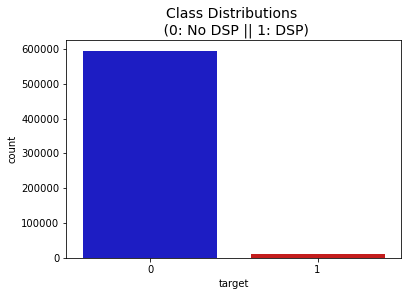

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('target', data=new_df, palette=colors)
plt.title('Class Distributions \n (0: No DSP || 1: DSP)', fontsize=14)

#### >> 여러 컬럼 Scaling

**Scaling&Encoding:**
- MinMaxScaler() - 'FP_IDEX', 'OLD_FP_IDEX', 'TEMPERATURES', 'scaled_TEMPERATURES','TEMP_DIFF', 'PRECIPITATION', 'dwelling_index', 'road_index', 'bar_cnt', 'covid_19'
- 다양하게 분포되어 있는 FEATURE의 값을 0-1 사이의 값으로 정규화시켜주기 위해 사용

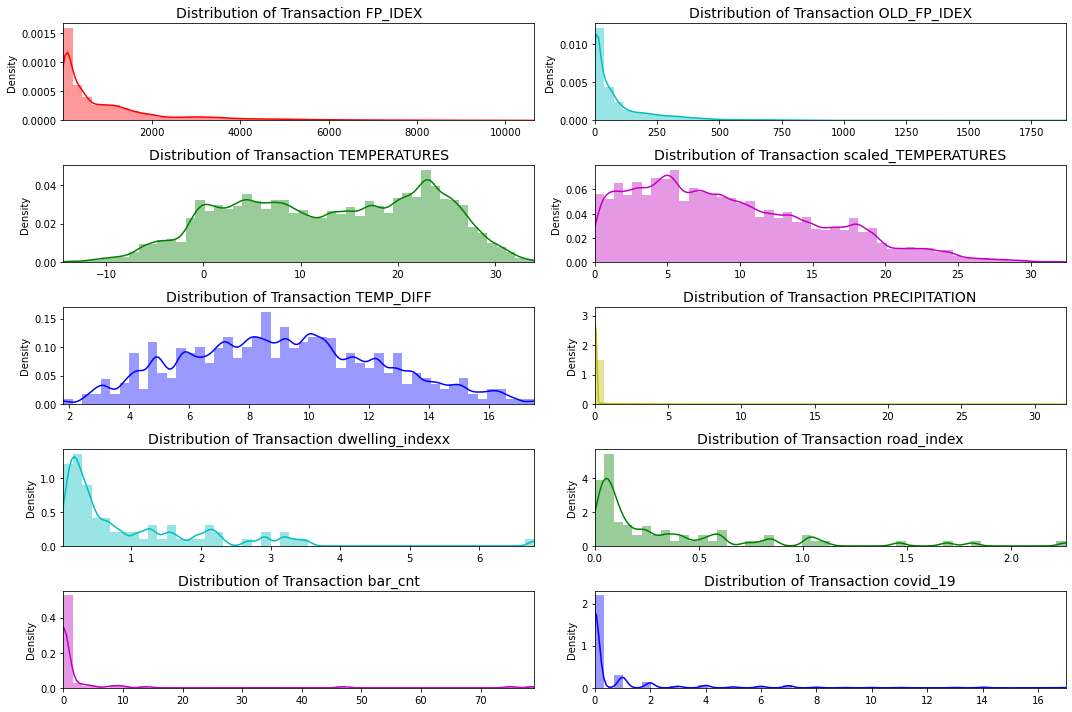

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15,10))

FP_IDEX_val = new_df['FP_IDEX'].values
OLD_FP_IDEX_val = new_df['OLD_FP_IDEX'].values
TEMPERATURES_val= new_df['TEMPERATURES'].values
scaled_TEMPERATURES_val = new_df['scaled_TEMPERATURES'].values
TEMP_DIFF_val = new_df['TEMP_DIFF'].values
PRECIPITATION_val= new_df['PRECIPITATION'].values
dwelling_indexx_val= new_df['dwelling_index'].values
road_index_val= new_df['road_index'].values
bar_cnt_val= new_df['bar_cnt'].values
covid_19_val= new_df['covid_19'].values

sns.distplot(FP_IDEX_val, ax=ax[0,0], color='r')
ax[0,0].set_title('Distribution of Transaction FP_IDEX', fontsize=14)
ax[0,0].set_xlim([min(FP_IDEX_val), max(FP_IDEX_val)])

sns.distplot(OLD_FP_IDEX_val, ax=ax[0,1], color='c')
ax[0,1].set_title('Distribution of Transaction OLD_FP_IDEX', fontsize=14)
ax[0,1].set_xlim([min(OLD_FP_IDEX_val), max(OLD_FP_IDEX_val)])

sns.distplot(TEMPERATURES_val, ax=ax[1,0], color='g')
ax[1,0].set_title('Distribution of Transaction TEMPERATURES', fontsize=14)
ax[1,0].set_xlim([min(TEMPERATURES_val), max(TEMPERATURES_val)])

sns.distplot(scaled_TEMPERATURES_val, ax=ax[1,1], color='m')
ax[1,1].set_title('Distribution of Transaction scaled_TEMPERATURES', fontsize=14)
ax[1,1].set_xlim([min(scaled_TEMPERATURES_val), max(scaled_TEMPERATURES_val)])

sns.distplot(TEMP_DIFF_val, ax=ax[2,0], color='b')
ax[2,0].set_title('Distribution of Transaction TEMP_DIFF', fontsize=14)
ax[2,0].set_xlim([min(TEMP_DIFF_val), max(TEMP_DIFF_val)])

sns.distplot(PRECIPITATION_val, ax=ax[2,1], color='y')
ax[2,1].set_title('Distribution of Transaction PRECIPITATION', fontsize=14)
ax[2,1].set_xlim([min(PRECIPITATION_val), max(PRECIPITATION_val)])

sns.distplot(dwelling_indexx_val, ax=ax[3,0], color='c')
ax[3,0].set_title('Distribution of Transaction dwelling_indexx', fontsize=14)
ax[3,0].set_xlim([min(dwelling_indexx_val), max(dwelling_indexx_val)])

sns.distplot(road_index_val, ax=ax[3,1], color='g')
ax[3,1].set_title('Distribution of Transaction road_index', fontsize=14)
ax[3,1].set_xlim([min(road_index_val), max(road_index_val)])

sns.distplot(bar_cnt_val, ax=ax[4,0], color='m')
ax[4,0].set_title('Distribution of Transaction bar_cnt', fontsize=14)
ax[4,0].set_xlim([min(bar_cnt_val), max(bar_cnt_val)])

sns.distplot(covid_19_val, ax=ax[4,1],  color='b')
ax[4,1].set_title('Distribution of Transaction covid_19', fontsize=14)
ax[4,1].set_xlim([min(covid_19_val), max(covid_19_val)])

fig.tight_layout()
plt.show()

In [ ]:
new_df.head()

,GRID_ID,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,target
0,38345224,0,1,1,2,1,4.18,0.34,-6.9,0.0,7.2,24.9,0.31,0.24,1.0,0.0,0
1,38345224,1,1,1,2,1,3.46,0.17,-6.6,0.0,7.2,24.6,0.31,0.24,1.0,0.0,0
2,38345224,2,1,1,2,1,2.04,0.34,-6.1,0.0,7.2,24.1,0.31,0.24,1.0,0.0,0
3,38345224,3,1,1,2,1,3.07,0.34,-6.7,0.0,7.2,24.7,0.31,0.24,1.0,0.0,0
4,38345224,4,1,1,2,1,1.53,0.17,-6.4,0.0,7.2,24.4,0.31,0.24,1.0,0.0,0


In [ ]:
minmax_scaler = MinMaxScaler()

new_df['FP_IDEX'] = minmax_scaler.fit_transform(new_df['FP_IDEX'].values.reshape(-1,1))
new_df['OLD_FP_IDEX'] = minmax_scaler.fit_transform(new_df['OLD_FP_IDEX'].values.reshape(-1,1))
new_df['TEMPERATURES'] = minmax_scaler.fit_transform(new_df['TEMPERATURES'].values.reshape(-1,1))
new_df['scaled_TEMPERATURES'] = minmax_scaler.fit_transform(new_df['scaled_TEMPERATURES'].values.reshape(-1,1))
new_df['TEMP_DIFF'] = minmax_scaler.fit_transform(new_df['TEMP_DIFF'].values.reshape(-1,1))
new_df['PRECIPITATION'] = minmax_scaler.fit_transform(new_df['PRECIPITATION'].values.reshape(-1,1))
new_df['dwelling_index'] = minmax_scaler.fit_transform(new_df['dwelling_index'].values.reshape(-1,1))
new_df['road_index'] = minmax_scaler.fit_transform(new_df['road_index'].values.reshape(-1,1))
new_df['bar_cnt'] = minmax_scaler.fit_transform(new_df['bar_cnt'].values.reshape(-1,1))
new_df['covid_19'] = minmax_scaler.fit_transform(new_df['covid_19'].values.reshape(-1,1))

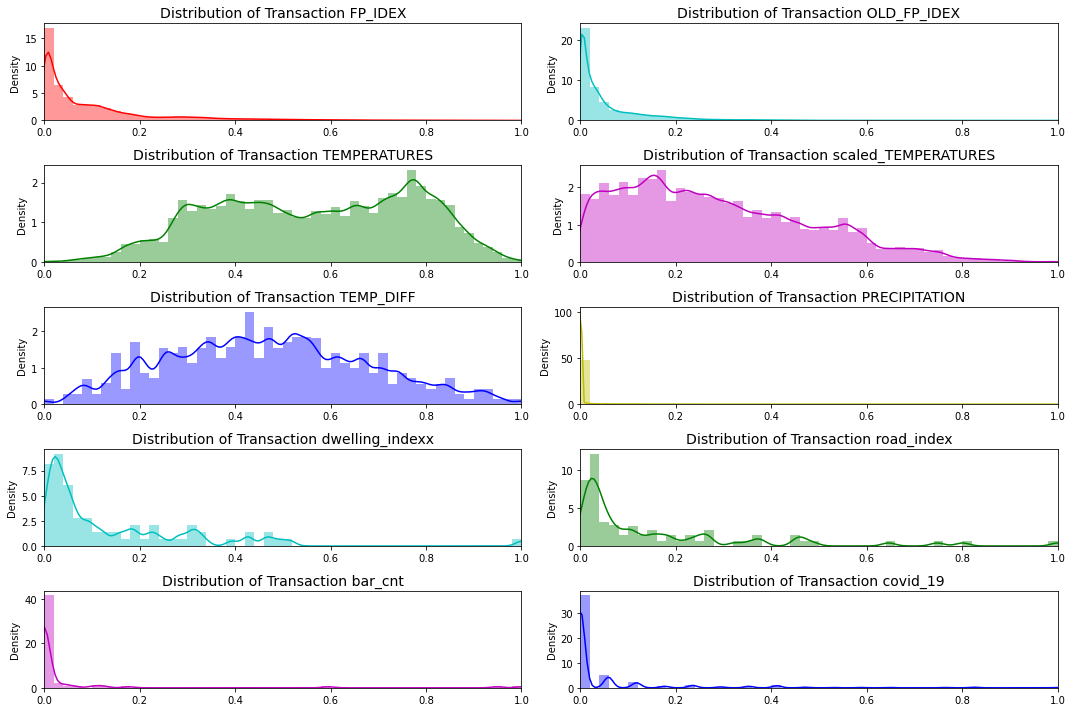

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15,10))

FP_IDEX_val = new_df['FP_IDEX'].values
OLD_FP_IDEX_val = new_df['OLD_FP_IDEX'].values
TEMPERATURES_val= new_df['TEMPERATURES'].values
scaled_TEMPERATURES_val = new_df['scaled_TEMPERATURES'].values
TEMP_DIFF_val = new_df['TEMP_DIFF'].values
PRECIPITATION_val= new_df['PRECIPITATION'].values
dwelling_indexx_val= new_df['dwelling_index'].values
road_index_val= new_df['road_index'].values
bar_cnt_val= new_df['bar_cnt'].values
covid_19_val= new_df['covid_19'].values

sns.distplot(FP_IDEX_val, ax=ax[0,0], color='r')
ax[0,0].set_title('Distribution of Transaction FP_IDEX', fontsize=14)
ax[0,0].set_xlim([min(FP_IDEX_val), max(FP_IDEX_val)])

sns.distplot(OLD_FP_IDEX_val, ax=ax[0,1], color='c')
ax[0,1].set_title('Distribution of Transaction OLD_FP_IDEX', fontsize=14)
ax[0,1].set_xlim([min(OLD_FP_IDEX_val), max(OLD_FP_IDEX_val)])

sns.distplot(TEMPERATURES_val, ax=ax[1,0], color='g')
ax[1,0].set_title('Distribution of Transaction TEMPERATURES', fontsize=14)
ax[1,0].set_xlim([min(TEMPERATURES_val), max(TEMPERATURES_val)])

sns.distplot(scaled_TEMPERATURES_val, ax=ax[1,1], color='m')
ax[1,1].set_title('Distribution of Transaction scaled_TEMPERATURES', fontsize=14)
ax[1,1].set_xlim([min(scaled_TEMPERATURES_val), max(scaled_TEMPERATURES_val)])

sns.distplot(TEMP_DIFF_val, ax=ax[2,0], color='b')
ax[2,0].set_title('Distribution of Transaction TEMP_DIFF', fontsize=14)
ax[2,0].set_xlim([min(TEMP_DIFF_val), max(TEMP_DIFF_val)])

sns.distplot(PRECIPITATION_val, ax=ax[2,1], color='y')
ax[2,1].set_title('Distribution of Transaction PRECIPITATION', fontsize=14)
ax[2,1].set_xlim([min(PRECIPITATION_val), max(PRECIPITATION_val)])

sns.distplot(dwelling_indexx_val, ax=ax[3,0], color='c')
ax[3,0].set_title('Distribution of Transaction dwelling_indexx', fontsize=14)
ax[3,0].set_xlim([min(dwelling_indexx_val), max(dwelling_indexx_val)])

sns.distplot(road_index_val, ax=ax[3,1], color='g')
ax[3,1].set_title('Distribution of Transaction road_index', fontsize=14)
ax[3,1].set_xlim([min(road_index_val), max(road_index_val)])

sns.distplot(bar_cnt_val, ax=ax[4,0], color='m')
ax[4,0].set_title('Distribution of Transaction bar_cnt', fontsize=14)
ax[4,0].set_xlim([min(bar_cnt_val), max(bar_cnt_val)])

sns.distplot(covid_19_val, ax=ax[4,1],  color='b')
ax[4,1].set_title('Distribution of Transaction covid_19', fontsize=14)
ax[4,1].set_xlim([min(covid_19_val), max(covid_19_val)])

fig.tight_layout()
plt.show()

In [ ]:
new_df.head()

,GRID_ID,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,target
0,38345224,0,1,1,2,1,0.000299,0.00018,0.154959,0.0,0.343949,0.768519,0.042836,0.106195,0.012658,0.0,0
1,38345224,1,1,1,2,1,0.000231,0.00009,0.161157,0.0,0.343949,0.759259,0.042836,0.106195,0.012658,0.0,0
2,38345224,2,1,1,2,1,0.000098,0.00018,0.171488,0.0,0.343949,0.743827,0.042836,0.106195,0.012658,0.0,0
3,38345224,3,1,1,2,1,0.000194,0.00018,0.159091,0.0,0.343949,0.762346,0.042836,0.106195,0.012658,0.0,0
4,38345224,4,1,1,2,1,0.000050,0.00009,0.165289,0.0,0.343949,0.753086,0.042836,0.106195,0.012658,0.0,0


#### >> One_Hot Encoding() - WEEKDAY

In [ ]:
new_df = pd.get_dummies(new_df, columns=['WEEKDAY'])
new_df

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,target,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,38345224,0,1,1,1,0.000299,0.000180,0.154959,0.0,0.343949,0.768519,0.042836,0.106195,0.012658,0.000000,0,0,0,1,0,0,0,0
1,38345224,1,1,1,1,0.000231,0.000090,0.161157,0.0,0.343949,0.759259,0.042836,0.106195,0.012658,0.000000,0,0,0,1,0,0,0,0
2,38345224,2,1,1,1,0.000098,0.000180,0.171488,0.0,0.343949,0.743827,0.042836,0.106195,0.012658,0.000000,0,0,0,1,0,0,0,0
3,38345224,3,1,1,1,0.000194,0.000180,0.159091,0.0,0.343949,0.762346,0.042836,0.106195,0.012658,0.000000,0,0,0,1,0,0,0,0
4,38345224,4,1,1,1,0.000050,0.000090,0.165289,0.0,0.343949,0.753086,0.042836,0.106195,0.012658,0.000000,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607005,38645324,17,11,7,0,0.000094,0.000053,0.626033,0.0,0.382166,0.064815,0.000000,0.026549,0.000000,0.470588,0,0,0,0,0,0,1,0
607006,38645324,12,11,8,0,0.001466,0.000805,0.572314,0.0,0.401274,0.145062,0.000000,0.026549,0.000000,0.588235,0,0,0,0,0,0,0,1
607007,38645324,15,11,12,0,0.010290,0.008432,0.638430,0.0,0.859873,0.046296,0.000000,0.026549,0.000000,0.411765,0,0,0,0,1,0,0,0
607008,38645324,16,11,12,0,0.000658,0.000614,0.630165,0.0,0.859873,0.058642,0.000000,0.026549,0.000000,0.411765,0,0,0,0,1,0,0,0


In [ ]:
new_df.columns

Index(['GRID_ID', 'TIME', 'MONTH', 'DAY', 'HOLIDAY', 'FP_IDEX', 'OLD_FP_IDEX',
       'TEMPERATURES', 'PRECIPITATION', 'TEMP_DIFF', 'scaled_TEMPERATURES',
       'dwelling_index', 'road_index', 'bar_cnt', 'covid_19', 'target',
       'WEEKDAY_0', 'WEEKDAY_1', 'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4',
       'WEEKDAY_5', 'WEEKDAY_6'],
      dtype='object')

#### >> Feature Description

모델에 적용되는 최종 변수는 다음과 같습니다

0. GRID_ID : 격자 ID
1. TIME : 시간
2. MONTH : 월
3. DAY : 일
4. HOLIDAY : 공휴일
5. FP_IDEX : 유동인구 지수
6. OLD_FP_IDEX : 노인 유동인구 지수
7. TEMPERATURES : 기온
8. PRECIPITATION : 강수량
9. TEMP_DIFF : 일교차
10. scaled_TEMPERATURES : 기온
11. dwelling_index : 주거지에 거주하는 인원 중 구급출동이 필요한 주거인구 지수
12. road_index : 도로에서 사고가 일어날 가능성 지수
13. bar_cnt : 격자내 유흥주점의 수
14. covid_19 : 일별 코로나 확진자 수
15. WEEKDAY_0 ~ WEEKDAY_6 : 요일(0:월 ~ 6:일)

In [ ]:
backup2 = new_df.copy()    # df copy 저장

# 5. 학습 데이터셋 및 머신러닝 예측 모델 생성

#### >> Distributing - X, y split

In [ ]:
## train, test set split (No DSP : DSP = 0.98: 0.02 같은 비율로) - > original_ 버전

print('No DSP', round(new_df['target'].value_counts()[0]/len(new_df) * 100,2), '% of the dataset')
print('DSP', round(new_df['target'].value_counts()[1]/len(new_df) * 100,2), '% of the dataset')

X = new_df.drop('target', axis=1)
y = new_df['target']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

## 교차검증을 위한 data split
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) # StratifiedKFold - KFOLD 교차검증

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

## train set과 test set이 기존 df의 dsp 0,1 비율과 같은 비율로 나누어졌는지 확인
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No DSP 98.01 % of the dataset
DSP 1.99 % of the dataset
Train: [119802 119803 119804 ... 607007 607008 607009] Test: [     0      1      2 ... 232979 233003 233069]
Train: [     0      1      2 ... 607007 607008 607009] Test: [119802 119803 119804 ... 288809 288820 288839]
Train: [     0      1      2 ... 607007 607008 607009] Test: [240665 240666 240667 ... 365136 365137 365138]
Train: [     0      1      2 ... 607007 607008 607009] Test: [318679 318684 318709 ... 487147 487148 487150]
Train: [     0      1      2 ... 487147 487148 487150] Test: [394675 394776 394787 ... 607007 607008 607009]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98014242 0.01985758]
[0.98014036 0.01985964]


#### >> Random Under-Sampling

**subsample 만들기 전 DSP_CNT_IDEX 0인값과 1인값 같은 비율로 new_df 생성**

In [ ]:
# subsample 만들기 전 df 데이터 shuffle
new_df = new_df.sample(frac=1) #frac - 추출할 표본 비율 0~1설정 1은 100%

# DSP_CNT_IDEX가 1인 갯수(12054) 만큼 데이터 생성
DSP_df = new_df.loc[new_df['target'] == 1]
non_DSP_df = new_df.loc[new_df['target'] == 0][:12054]

normal_distributed_df = pd.concat([DSP_df, non_DSP_df])

# df 행 shuffle
sub_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_df.head()

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,target,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
418463,39645304,10,1,25,1,0.070741,0.034421,0.340909,0.0,0.528662,0.490741,0.088626,0.026549,0.0,0.000000,0,0,0,0,0,0,1,0
427288,39645314,3,2,9,0,0.070120,0.029474,0.208678,0.0,0.573248,0.688272,0.221566,0.106195,0.0,0.000000,0,0,0,0,0,0,0,1
144584,39245224,22,10,29,0,0.019377,0.006880,0.442149,0.0,0.719745,0.339506,0.016248,0.008850,0.0,0.294118,0,0,0,0,1,0,0,0
252843,39445274,14,7,28,0,0.358148,0.224809,0.822314,0.0,0.127389,0.228395,0.423929,0.747788,0.0,0.000000,0,0,1,0,0,0,0,0
319879,39545284,18,6,18,0,0.147824,0.114889,0.791322,0.0,0.197452,0.182099,0.158050,0.455752,0.0,0.000000,1,0,0,0,1,0,0,0


#### >> Equally Distributing and Correlating

**subsampling 후 target 값인 '0'과 '1'의 값이 같아졌음을 확인**

Distribution of the DSP_CNT_IDEX in the subsample dataset
0    0.5
1    0.5
Name: target, dtype: float64


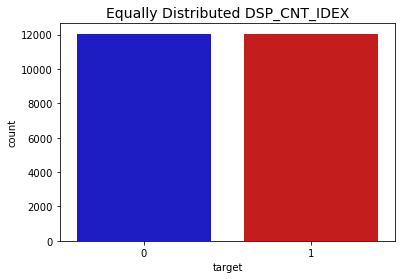

In [ ]:
print('Distribution of the DSP_CNT_IDEX in the subsample dataset')
print(sub_df['target'].value_counts()/len(sub_df))

sns.countplot('target', data=sub_df, palette=colors)
plt.title('Equally Distributed DSP_CNT_IDEX', fontsize=14)
plt.show()

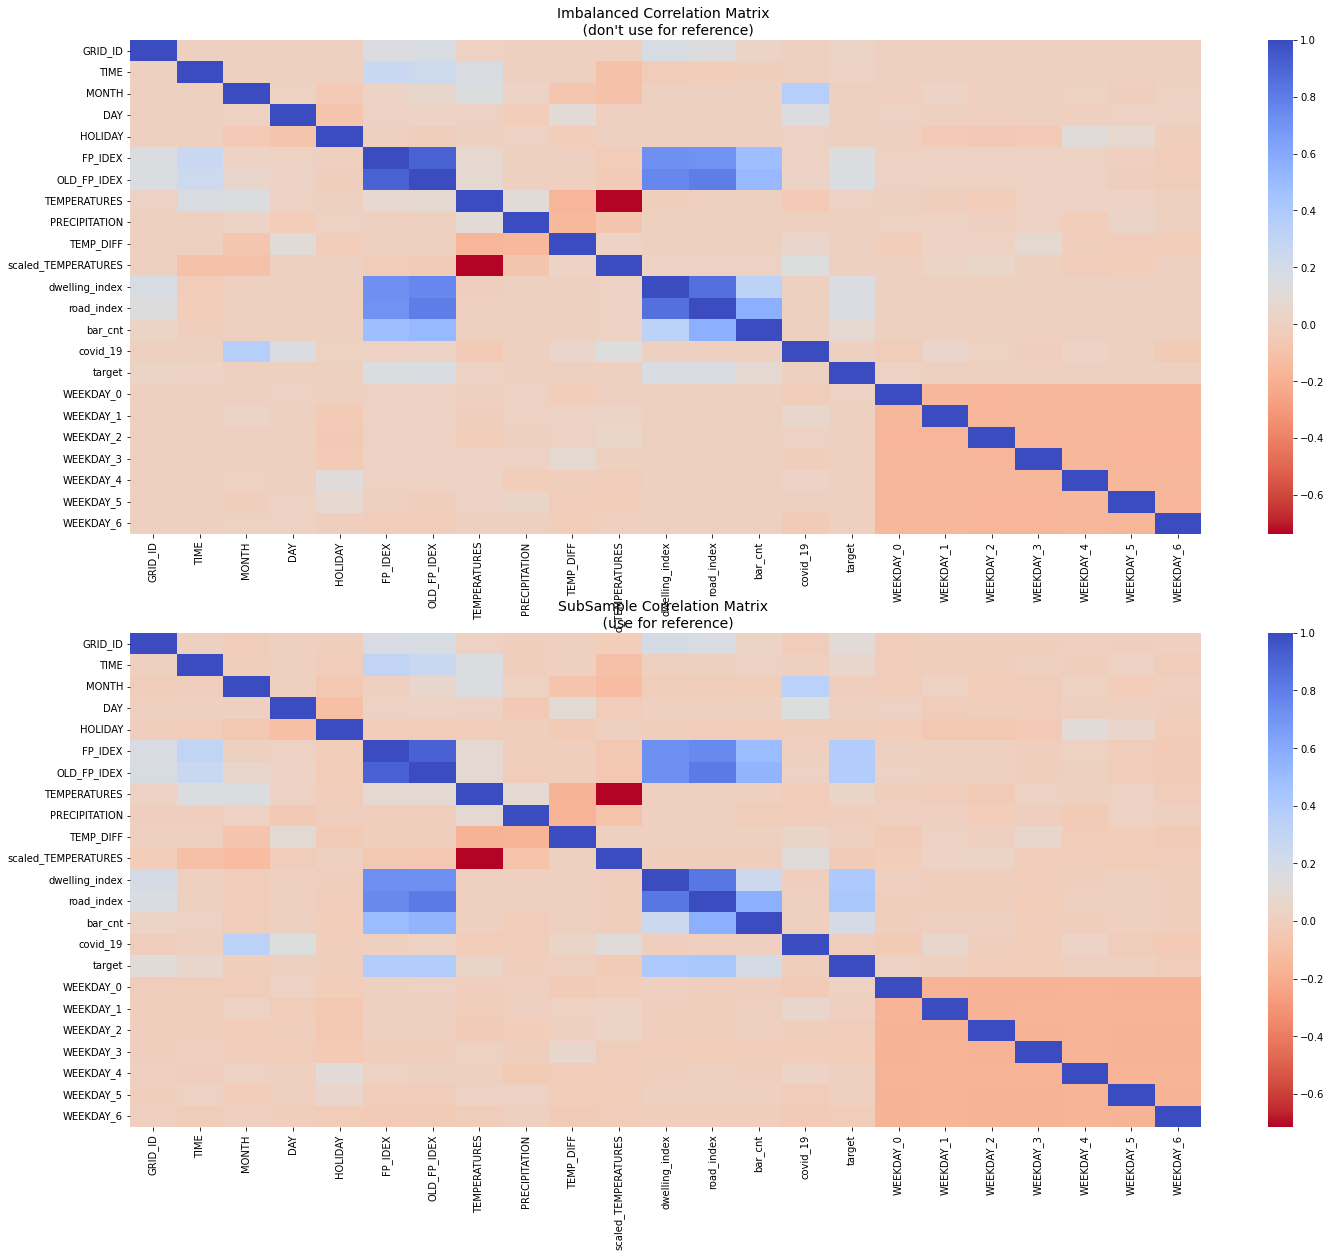

In [ ]:
# feature값과 target값의 상관관계 확인
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# sub_sample DataFrame
sub_sample_corr = sub_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()


In [ ]:
# DSP_CNT_IDEX를 기준으로 feature 상관계수 순으로 내림차순 정렬
sub_sample_corr['target'].sort_values(ascending=False)

target                 1.000000
road_index             0.417767
dwelling_index         0.412845
FP_IDEX                0.386217
OLD_FP_IDEX            0.378207
bar_cnt                0.189678
GRID_ID                0.111180
TIME                   0.064738
TEMPERATURES           0.046120
WEEKDAY_0              0.018377
DAY                    0.012281
WEEKDAY_5              0.004269
WEEKDAY_1              0.003125
TEMP_DIFF              0.002836
WEEKDAY_4              0.001807
MONTH                  0.001220
PRECIPITATION          0.001186
HOLIDAY               -0.002743
covid_19              -0.003404
WEEKDAY_6             -0.006481
WEEKDAY_2             -0.006788
WEEKDAY_3             -0.014163
scaled_TEMPERATURES   -0.028640
Name: target, dtype: float64

#### >> Classifiers (UnderSampling)

**new_df(dsp 1과 0의 비율 50대 50으로 만든 dataset) 사용하여 x,y split**
**undersampling은 불균형한 데이터 셋에서 높은 비율을 차지하던 클래스의 데이터 수를 줄임으로써 데이터 불균형을 해소하는 아이디어**

In [ ]:
X = sub_df.drop('target', axis=1)
y = sub_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [ ]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 50.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 68.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 62.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 70.0 % accuracy score


#### >> 각 모델 하이퍼 파라미터 탐색 후 모델 적용

In [ ]:
# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

print('최적 하이퍼 파라미터: ', grid_log_reg.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_log_reg.best_score_))

최적 하이퍼 파라미터:  {'C': 0.001, 'penalty': 'l2'}
최고 예측 정확도: 0.4995


In [ ]:
# K-Nearest Neighbor
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

print('최적 하이퍼 파라미터: ', grid_knears.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_knears.best_score_))

최적 하이퍼 파라미터:  {'algorithm': 'ball_tree', 'n_neighbors': 3}
최고 예측 정확도: 0.6671


In [ ]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,6,1)),
              "min_samples_leaf": list(range(5,10,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

print('최적 하이퍼 파라미터: ', grid_tree.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_tree.best_score_))

최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5}
최고 예측 정확도: 0.7243


In [ ]:
# 시간이 많이 소요되어 결과를 토대로 아래 모델로 만듬
# #RandomForestClassifier
# rf_params = { 'n_estimators' : [100],
#            'max_depth' : [4, 6, 8],
#            'min_samples_leaf' : [8, 12, 18, 20],
#            'min_samples_split' : [6, 8, 16]
#             }
# grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
# grid_rf.fit(X_train, y_train)

# # tree best estimator
# rf_clf = grid_rf.best_estimator_

# print('최적 하이퍼 파라미터: ', grid_rf.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_rf.best_score_))

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_depth=8,
                                min_samples_split=6,
                                min_samples_leaf=8)

In [ ]:
# undersampling date 모델 알고리즘 평가 - f1 score

log_reg_score = cross_val_score(log_reg, X_train, y_train, scoring="f1", cv=5)
print('Logistic Regression F1 Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%') # round()는 반올림함수

knears_score = cross_val_score(knears_neighbors, X_train, y_train, scoring="f1", cv=5)
print('Knears Neighbors F1 Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, scoring="f1", cv=5)
print('DecisionTree Classifier F1 Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

ran_for_score = cross_val_score(rf_clf, X_train, y_train, scoring="f1", cv=5)
print('RandomForest Classifier F1 Score', round(ran_for_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression F1 Score:  66.63%
Knears Neighbors F1 Score 66.87%
DecisionTree Classifier F1 Score 73.09%
RandomForest Classifier F1 Score 73.42%


#### >> df를 이용하여 undersampling

**불균형한 데이터 셋에서 높은 비율을 차지하던 클래스의 데이터 수를 줄임으로써 데이터 불균형을 해소하는 아이디어**

In [ ]:
undersample_X = new_df.drop('target', axis=1)
undersample_y = new_df['target']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

Train: [121383 121384 121385 ... 607007 607008 607009] Test: [     0      1      2 ... 122048 122061 122157]
Train: [     0      1      2 ... 607007 607008 607009] Test: [121383 121384 121385 ... 243498 243608 243697]
Train: [     0      1      2 ... 607007 607008 607009] Test: [242788 242789 242790 ... 366321 366373 366512]
Train: [     0      1      2 ... 607007 607008 607009] Test: [364149 364150 364151 ... 486380 486531 486566]
Train: [     0      1      2 ... 486380 486531 486566] Test: [485594 485595 485596 ... 607007 607008 607009]


In [ ]:
# NearMiss는 undersampling 하는 methods
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# NearMiss()를 이용하여 undersampling
# NearMiss()의 defalut 값인 첫번째 방법은 다수 클래스 데이터 포인트와 가장 가까운 소수 클래스 데이터
# 3개와의 평균 거리를 계산하고 평균 거리가 가장 작은 데이터를 비율에 맞게 남기고 그 외에는 삭제하는 방법

X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):  # sss는 KFOLD 교차검증
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(), tree_clf)
    # tree모델 적용 - ramdomforest 모델과 f1 score가 비슷함을 보였지만 시간과 성능을 고려하여 tree 모델적용
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

NearMiss Label Distribution: Counter({0: 12054, 1: 12054})


#### >> cross_val_score는 테스트 폴드의 점수를 반환, cross_val_predict는 테스트 폴드에 대한 예측 된 y 값을 반환

In [ ]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5) # method의 default값은 predict

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)

In [ ]:
# undersampling 한 df 머신러닝 모델 적용 후, auc 확인
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))

Logistic Regression:  0.5067259458295454
KNears Neighbors:  0.6670694668979124
Decision Tree Classifier:  0.7242796032252466
Random Forest Classifier:  0.7237757068250389


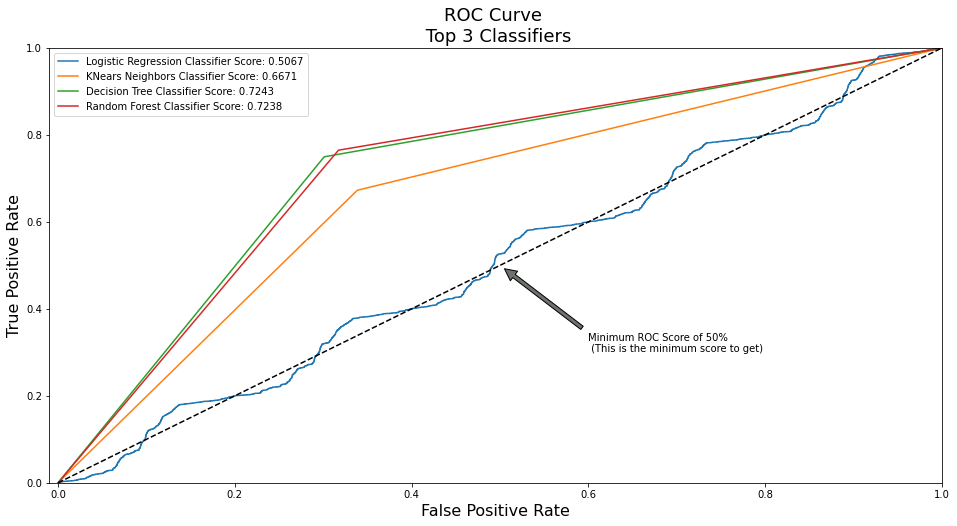

In [ ]:
# roc_curve 그래프
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr)
plt.show()

#### >> A Deeper Look into Decision Tree Classifier

**가장 높은 점수를 받은 Decision Tree Classifier 살펴보기**

In [ ]:
tree_clf = grid_tree.best_estimator_
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)

[Text(446.4, 440.31600000000003, 'X[11] <= 0.124\ngini = 0.5\nsamples = 19286\nvalue = [9652, 9634]'),
 Text(223.2, 342.468, 'X[11] <= 0.041\ngini = 0.357\nsamples = 7934\nvalue = [6088, 1846]'),
 Text(111.6, 244.62, 'X[1] <= 7.5\ngini = 0.274\nsamples = 4024\nvalue = [3365, 659]'),
 Text(55.8, 146.772, 'X[0] <= 39245274.0\ngini = 0.19\nsamples = 999\nvalue = [893, 106]'),
 Text(27.9, 48.924000000000035, 'gini = 0.146\nsamples = 493\nvalue = [454, 39]'),
 Text(83.69999999999999, 48.924000000000035, 'gini = 0.23\nsamples = 506\nvalue = [439, 67]'),
 Text(167.39999999999998, 146.772, 'X[5] <= 0.0\ngini = 0.299\nsamples = 3025\nvalue = [2472, 553]'),
 Text(139.5, 48.924000000000035, 'gini = 0.465\nsamples = 87\nvalue = [55, 32]'),
 Text(195.29999999999998, 48.924000000000035, 'gini = 0.292\nsamples = 2938\nvalue = [2417, 521]'),
 Text(334.79999999999995, 244.62, 'X[1] <= 7.5\ngini = 0.423\nsamples = 3910\nvalue = [2723, 1187]'),
 Text(279.0, 146.772, 'X[12] <= 0.111\ngini = 0.336\nsamples

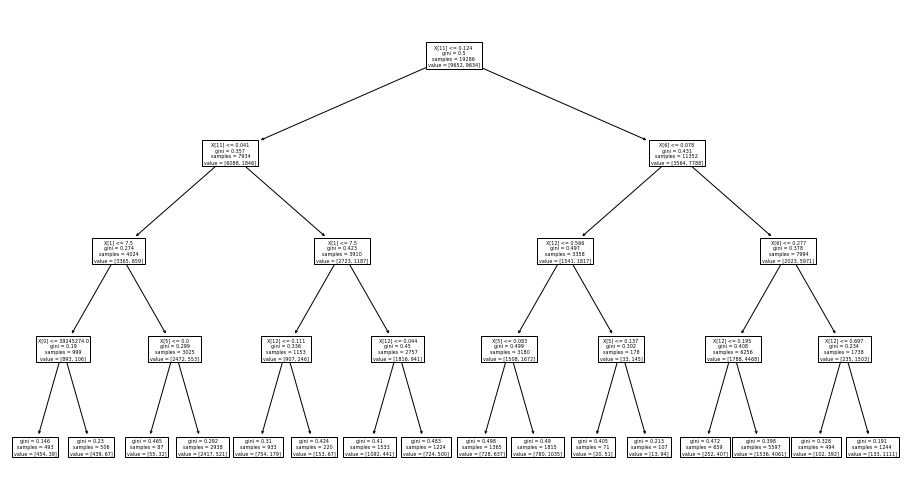

In [ ]:
# tree를 확인해 상관성이 높은 feature 확인 -> 'dwelling_index' , 'OLD_FP_IDEX'
plt.figure(figsize=(16,9))
tree.plot_tree(tree_clf)

**DecisionTree 모델에 'dwelling_index'가 가장 많은 영향을 미침**

In [ ]:
X

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
418463,39645304,10,1,25,1,0.070741,0.034421,0.340909,0.0,0.528662,0.490741,0.088626,0.026549,0.000000,0.000000,0,0,0,0,0,1,0
427288,39645314,3,2,9,0,0.070120,0.029474,0.208678,0.0,0.573248,0.688272,0.221566,0.106195,0.000000,0.000000,0,0,0,0,0,0,1
144584,39245224,22,10,29,0,0.019377,0.006880,0.442149,0.0,0.719745,0.339506,0.016248,0.008850,0.000000,0.294118,0,0,0,1,0,0,0
252843,39445274,14,7,28,0,0.358148,0.224809,0.822314,0.0,0.127389,0.228395,0.423929,0.747788,0.000000,0.000000,0,1,0,0,0,0,0
319879,39545284,18,6,18,0,0.147824,0.114889,0.791322,0.0,0.197452,0.182099,0.158050,0.455752,0.000000,0.000000,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601886,39845224,8,2,21,0,0.000239,0.000238,0.303719,0.0,0.668790,0.546296,0.031019,0.008850,0.000000,0.000000,0,0,0,0,1,0,0
256731,39445284,14,1,12,0,0.305108,0.163160,0.340909,0.0,0.159236,0.490741,0.392910,0.269912,0.000000,0.000000,0,0,0,0,0,0,1
357131,39545334,22,11,6,0,0.012774,0.011186,0.537190,0.0,0.407643,0.197531,0.073855,0.039823,0.000000,0.235294,0,0,0,0,1,0,0
553571,40045254,22,12,20,0,0.155658,0.060326,0.177686,0.0,0.630573,0.734568,0.011817,0.000000,0.000000,0.117647,0,0,0,0,0,0,1


In [ ]:
# precision_recall_curve를 이용해 임곗값에 따른 정밀도-재현율 값 추출
precision, recall, threshold = precision_recall_curve(y_train, tree_pred)

In [ ]:
y_pred = tree_clf.predict(X_train)

# Overfitting Case - 기존 y_train 점수
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like - undersampling 점수
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.74
Precision Score: 0.72
F1 Score: 0.73
Accuracy Score: 0.72
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.15
Precision Score: 0.02
Recall Score: 0.87
F1 Score: 0.04
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# undersample_y_score = tree_clf.predict_proba(original_Xtest)
undersample_y_score = tree_clf.predict_proba(original_Xtest)[:,1]
undersample_y_score

array([0.46666667, 0.72556727, 0.72556727, ..., 0.17733152, 0.17733152,
       0.17733152])

In [ ]:
#average_precision_score - 정밀도(Precision)-재현율(Recall) 곡선 아래 면적
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.10


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.10')

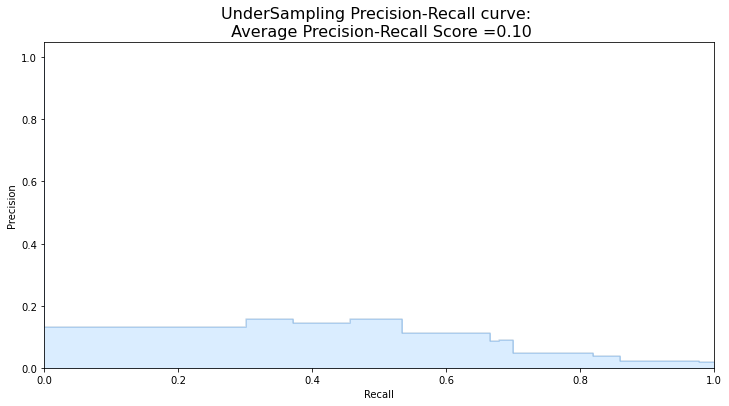

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

#### >> SMOTE Technique (Over-Sampling)

In [ ]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# DecisionTreeClassifier모델의 최적의 하이퍼파라미터 탐색
tree_sm = DecisionTreeClassifier()
rand_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=4)

# Cross Validating the right way
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_tree) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_tree.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 485608 | Length of y (train): 485608
Length of X (test): 121402 | Length of y (test): 121402
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.6430803608737972
precision: 0.06576322922331904
recall: 0.48935288853898457
f1: 0.09548605516888478
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
labels = ['No DSP', 'DSP']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

      No DSP       0.98      1.00      0.99    118991
         DSP       0.00      0.00      0.00      2411

    accuracy                           0.98    121402
   macro avg       0.49      0.50      0.49    121402
weighted avg       0.96      0.98      0.97    121402



In [ ]:
y_score = best_est.predict_proba(original_Xtest)[:,1]

In [ ]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

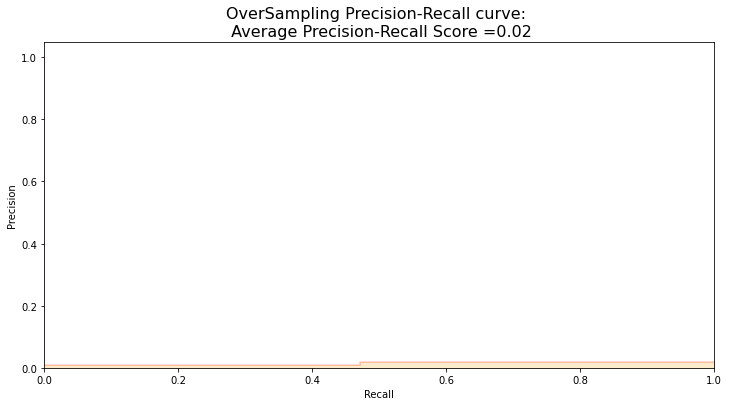

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling)
sm = SMOTE(random_state=42)
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
t0 = time.time()
tree_sm = grid_tree.best_estimator_
tree_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :10.57994794845581 sec


#### >> Test Data with DecisionTreeClassifier

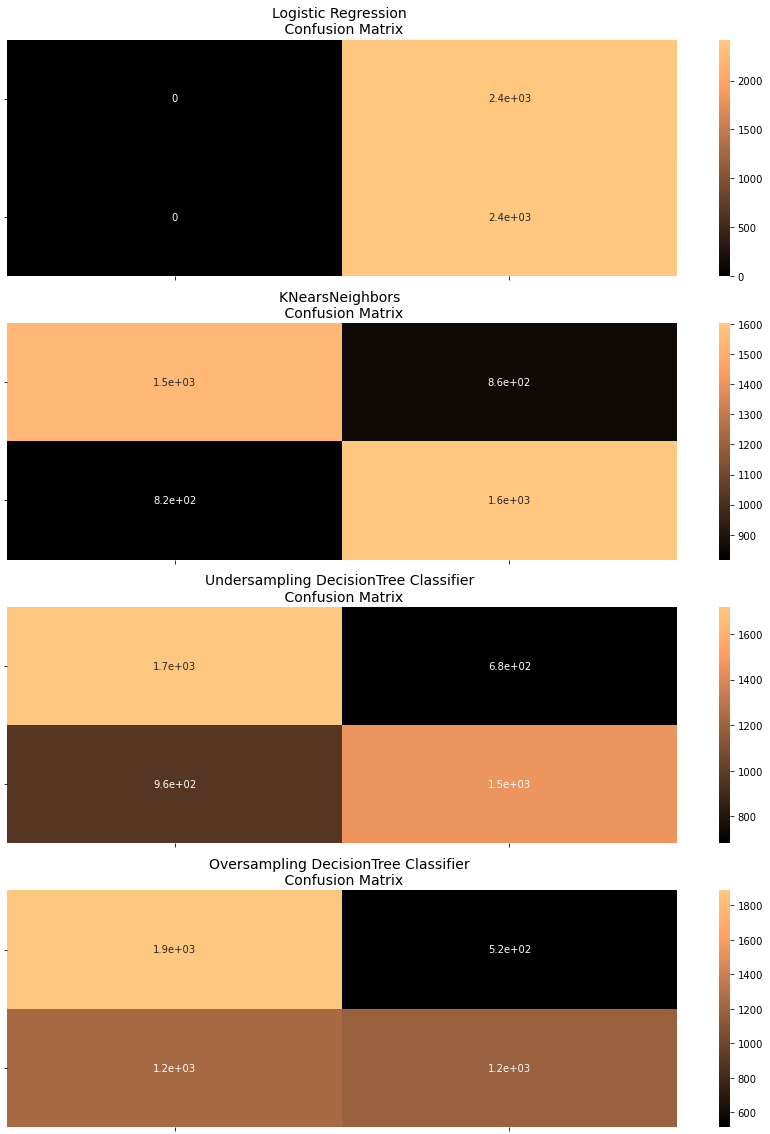

In [ ]:
# Decision Tree Classifier fitted using SMOTE technique
y_pred_overtree = best_est.predict(X_test)
# Decision Tree Classifier fitted using NearMiss technique
y_pred_undertree = tree_clf.predict(X_test)
# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
tree_cf1 = confusion_matrix(y_test, y_pred_undertree)
tree_cf2 = confusion_matrix(y_test, y_pred_overtree)


fig, (ax1,ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(15,20))


sns.heatmap(log_reg_cf, ax=ax1, annot=True, cmap=plt.cm.copper)
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax2, annot=True, cmap=plt.cm.copper)
ax2.set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf1, ax=ax3, annot=True, cmap=plt.cm.copper)
ax3.set_title("Undersampling DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax3.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax3.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf2, ax=ax4, annot=True, cmap=plt.cm.copper)
ax4.set_title("Oversampling DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax4.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax4.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [ ]:
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_undertree))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_overtree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2402
           1       0.50      1.00      0.67      2420

    accuracy                           0.50      4822
   macro avg       0.25      0.50      0.33      4822
weighted avg       0.25      0.50      0.34      4822

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2402
           1       0.65      0.66      0.66      2420

    accuracy                           0.65      4822
   macro avg       0.65      0.65      0.65      4822
weighted avg       0.65      0.65      0.65      4822

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      2402
           1       0.68      0.60      0.64      2420

    accuracy                           0.66      4822
   macro avg       0.66      0.66      0.66      4822
weighted 

In [ ]:
# Decision Tree Classifier with Under-Sampling
y_pred = tree_clf.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Decision Tree Classifier with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

,Technique,Score
0,Random UnderSampling,0.658855
1,Oversampling (SMOTE),0.980140


# 6. 모델 예측 결과

#### >> 매달 말일의 데이터프레임 생성 - finally_df


In [ ]:
# 예측 결과
results = []

# 해당 날짜들
Pred_Dates = [20200131 , 20200229 , 20200331 , 20200430 , 20200531 , 20200630 , 20200731 , 20200831 , 20200930 , 20201031 , 20201130 , 20201231]

# 시간대 (0 ~ 23)
Hours = [i for i in range(24)]

# 격자들
Grid_IDs = new_df["GRID_ID"].unique()
Inputs = []
for date in Pred_Dates:
    grid_id_lst = []
    hour_lst = []

    for hour in Hours:

        for grid_id in Grid_IDs:

            # 날짜로부터 년/월/일자/요일 계산
            date = date
            year = int(date/10000)
            month = int(date%10000/100)
            day = int(date%10000%100)
            weekday =  datetime.date(year,month,day).weekday()

            input = [grid_id]
            input += [date, hour, month, day, weekday]
            Inputs.append(input)

    last_df = pd.DataFrame(data=Inputs ,
                             columns=['GRID_ID', 'YMD', 'TIME', 'MONTH', 'DAY','WEEKDAY'])

last_df['YMD'] = toDatetime(last_df['YMD'])
last_df

,GRID_ID,YMD,TIME,MONTH,DAY,WEEKDAY
0,39345264,2020-01-31,0,1,31,4
1,39545244,2020-01-31,0,1,31,4
2,39645304,2020-01-31,0,1,31,4
3,38545254,2020-01-31,0,1,31,4
4,39745314,2020-01-31,0,1,31,4
...,...,...,...,...,...,...
21883,39745254,2020-12-31,23,12,31,3
21884,38645244,2020-12-31,23,12,31,3
21885,38345224,2020-12-31,23,12,31,3
21886,39845244,2020-12-31,23,12,31,3


In [ ]:
# holidays 데이터 가져오기
holiday_list=last_df.YMD
kr_holidays = holidays.KR()

# HOLIDAY는 1 NON_HOLIDAY는 0으로 표시
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(holiday_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
last_df['HOLIDAY'] = holiday_df['holiday']

last_df

,GRID_ID,YMD,TIME,MONTH,DAY,WEEKDAY,HOLIDAY
0,39345264,2020-01-31,0,1,31,4,0
1,39545244,2020-01-31,0,1,31,4,0
2,39645304,2020-01-31,0,1,31,4,0
3,38545254,2020-01-31,0,1,31,4,0
4,39745314,2020-01-31,0,1,31,4,0
...,...,...,...,...,...,...,...
21883,39745254,2020-12-31,23,12,31,3,0
21884,38645244,2020-12-31,23,12,31,3,0
21885,38345224,2020-12-31,23,12,31,3,0
21886,39845244,2020-12-31,23,12,31,3,0


In [ ]:
## 러닝타임이 길어 csv 파일로 대체
## 유동인구(FP_IDEX), 노인 유동인구(OLD_FP_IDEX) 컬럼 추가
## - > 같은 달, 같은 요일의 지난 3주간 유동인구의 평균값으로 계산
fp = []
old_fp = []
df1 = pd.DataFrame()

for m in range(1,13):
    w = last_df[last_df['MONTH']==m]['WEEKDAY'].unique()[0]
    for t in range(24):
        for g in last_df['GRID_ID'].unique():
            df1 = pd.concat([df1, df[(df.GRID_ID==g) & (df.MONTH==m) & (df.TIME==t) & (df.WEEKDAY==w)]], axis=0)
            fp.append(df1['FP_IDEX'].mean())
            old_fp.append(df1['OLD_FP_IDEX'].mean())

In [ ]:
fp_df = pd.DataFrame({'FP_IDEX' : fp,
                      'OLD_FP_IDEX' : old_fp})
fp_df

In [ ]:
fp_df.to_csv('fp_df.csv', index=False, encoding='cp949')

In [ ]:
fp_df = pd.read_csv("./data/fp_df.csv")

In [ ]:
last_df = pd.concat([last_df, fp_df], axis=1)
last_df

,GRID_ID,YMD,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX
0,39345264,2020-01-31,0,1,31,4,0,4.075000,0.435000
1,39545244,2020-01-31,0,1,31,4,0,3.255000,0.328333
2,39645304,2020-01-31,0,1,31,4,0,98.196000,7.989000
3,38545254,2020-01-31,0,1,31,4,0,97.435000,7.121429
4,39745314,2020-01-31,0,1,31,4,0,78.313889,5.673333
...,...,...,...,...,...,...,...,...,...
21883,39745254,2020-12-31,23,12,31,3,0,1086.391756,107.835390
21884,38645244,2020-12-31,23,12,31,3,0,1086.391756,107.835390
21885,38345224,2020-12-31,23,12,31,3,0,1086.338098,107.830105
21886,39845244,2020-12-31,23,12,31,3,0,1086.284792,107.824938


In [ ]:
# 매달 말일 날짜
date = {'YMD': ['20200131', '20200229', '20200331', '20200430', '20200531', '20200630',
                '20200731', '20200831', '20200930', '20201031', '20201130', '20201231']}
date_df = pd.DataFrame(date)

last_climate = df_climate(date_df)
last_climate

# 'TIME' 컬럼 타입 변환 (object to int)
for i in last_climate.index:
    last_climate['TIME'][i] = int(last_climate['TIME'][i][:2])
last_climate['TIME'] = last_climate['TIME'].astype('int')

# 'TEMPERATURES'의 nan 처리 : 이전 시간의 기온 데이터로 채우기
last_climate['TEMPERATURES'].fillna(method='bfill', inplace=True)

# 'PRECIPITATION'의 nan 처리 : 0 으로 채우기
last_climate['PRECIPITATION'].fillna(0, inplace=True)

# 컬럼 타입 변환
last_climate['TEMPERATURES'] = last_climate['TEMPERATURES'].astype('float')
last_climate['PRECIPITATION'] = last_climate['PRECIPITATION'].astype('float')

## 일교차 컬럼 추가
for i in last_climate['YMD'].unique():
    last_climate.loc[last_climate['YMD'] == i, 'TEMP_DIFF'] = float(last_climate[last_climate['YMD'] == i].TEMPERATURES.max()) - float(last_climate[last_climate['YMD'] == i].TEMPERATURES.min())

last_climate

,YMD,TIME,TEMPERATURES,PRECIPITATION,TEMP_DIFF
0,2020-01-31,0,2.8,0.0,5.9
1,2020-01-31,1,2.3,0.0,5.9
2,2020-01-31,2,2.4,0.0,5.9
3,2020-01-31,3,2.5,0.0,5.9
4,2020-01-31,4,2.0,0.0,5.9
...,...,...,...,...,...
283,2020-12-31,19,-6.0,0.0,8.1
284,2020-12-31,20,-6.1,0.0,8.1
285,2020-12-31,21,-6.7,0.0,8.1
286,2020-12-31,22,-6.8,0.0,8.1


In [ ]:
last_climate.to_csv('./data/last_climate.csv', index=False, encoding='cp949')

In [ ]:
last_climate = pd.read_csv('./data/last_climate.csv')
last_climate

,YMD,TIME,TEMPERATURES,PRECIPITATION,TEMP_DIFF
0,2020-01-31,0,2.8,0.0,5.9
1,2020-01-31,1,2.3,0.0,5.9
2,2020-01-31,2,2.4,0.0,5.9
3,2020-01-31,3,2.5,0.0,5.9
4,2020-01-31,4,2.0,0.0,5.9
...,...,...,...,...,...
283,2020-12-31,19,-6.0,0.0,8.1
284,2020-12-31,20,-6.1,0.0,8.1
285,2020-12-31,21,-6.7,0.0,8.1
286,2020-12-31,22,-6.8,0.0,8.1


In [ ]:
# 18도를 기준으로 절댓값처리
last_climate['scaled_TEMPERATURES'] = np.where(last_climate['TEMPERATURES'] >= 18, last_climate['TEMPERATURES'] - 18, 18 - last_climate['TEMPERATURES'])
last_climate

,YMD,TIME,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES
0,2020-01-31,0,2.8,0.0,5.9,15.2
1,2020-01-31,1,2.3,0.0,5.9,15.7
2,2020-01-31,2,2.4,0.0,5.9,15.6
3,2020-01-31,3,2.5,0.0,5.9,15.5
4,2020-01-31,4,2.0,0.0,5.9,16.0
...,...,...,...,...,...,...
283,2020-12-31,19,-6.0,0.0,8.1,24.0
284,2020-12-31,20,-6.1,0.0,8.1,24.1
285,2020-12-31,21,-6.7,0.0,8.1,24.7
286,2020-12-31,22,-6.8,0.0,8.1,24.8


In [ ]:
# 기존 last_df에 합치기
last_climate['YMD'] = toDatetime(last_climate['YMD'])
last_df = pd.merge(last_df, last_climate, on=['YMD','TIME'])
last_df

,GRID_ID,YMD,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES
0,39345264,2020-01-31,0,1,31,4,0,4.075000,0.435000,2.8,0.0,5.9,15.2
1,39545244,2020-01-31,0,1,31,4,0,3.255000,0.328333,2.8,0.0,5.9,15.2
2,39645304,2020-01-31,0,1,31,4,0,98.196000,7.989000,2.8,0.0,5.9,15.2
3,38545254,2020-01-31,0,1,31,4,0,97.435000,7.121429,2.8,0.0,5.9,15.2
4,39745314,2020-01-31,0,1,31,4,0,78.313889,5.673333,2.8,0.0,5.9,15.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,39745254,2020-12-31,23,12,31,3,0,1086.391756,107.835390,-7.0,0.0,8.1,25.0
21884,38645244,2020-12-31,23,12,31,3,0,1086.391756,107.835390,-7.0,0.0,8.1,25.0
21885,38345224,2020-12-31,23,12,31,3,0,1086.338098,107.830105,-7.0,0.0,8.1,25.0
21886,39845244,2020-12-31,23,12,31,3,0,1086.284792,107.824938,-7.0,0.0,8.1,25.0


In [ ]:
## last_df 'dwelling_index', 'road_index', 'bar_cnt', 'covid_19' 컬럼 merge

### 'dwelling_index'
last_df = pd.merge(last_df, dwelling, on=['GRID_ID'])

### 'road_index'
last_df = pd.merge(last_df, road, on=['GRID_ID'])

### 'bar_cnt'
last_df = pd.merge(last_df, bar, on=['GRID_ID'], how = 'left')
last_df = last_df.fillna({'bar_cnt':0})

### 'covid_19'
corona['YMD'] = toDatetime(corona['YMD'])
last_df = pd.merge(last_df, corona, on=['YMD'], how='left')
last_df = last_df.fillna({'covid_19':0})

last_df

,GRID_ID,YMD,TIME,MONTH,DAY,WEEKDAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19
0,39345264,2020-01-31,0,1,31,4,0,4.075000,0.435000,2.8,0.0,5.9,15.2,1.53,0.85,47.0,0.0
1,39345264,2020-01-31,1,1,31,4,0,526.029310,39.461686,2.3,0.0,5.9,15.7,1.53,0.85,47.0,0.0
2,39345264,2020-01-31,2,1,31,4,0,540.035328,40.737471,2.4,0.0,5.9,15.6,1.53,0.85,47.0,0.0
3,39345264,2020-01-31,3,1,31,4,0,535.715135,41.002619,2.5,0.0,5.9,15.5,1.53,0.85,47.0,0.0
4,39345264,2020-01-31,4,1,31,4,0,529.469370,41.071996,2.0,0.0,5.9,16.0,1.53,0.85,47.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,38645324,2020-12-31,19,12,31,3,0,1080.273460,107.128303,-6.0,0.0,8.1,24.0,0.02,0.06,0.0,6.0
21884,38645324,2020-12-31,20,12,31,3,0,1082.186926,107.332265,-6.1,0.0,8.1,24.1,0.02,0.06,0.0,6.0
21885,38645324,2020-12-31,21,12,31,3,0,1083.931909,107.527162,-6.7,0.0,8.1,24.7,0.02,0.06,0.0,6.0
21886,38645324,2020-12-31,22,12,31,3,0,1085.413469,107.696477,-6.8,0.0,8.1,24.8,0.02,0.06,0.0,6.0


In [ ]:
## 'WEEKDAY' 원핫
finally_df = pd.get_dummies(last_df, columns=['WEEKDAY'])
finally_df

,GRID_ID,YMD,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,39345264,2020-01-31,0,1,31,0,4.075000,0.435000,2.8,0.0,5.9,15.2,1.53,0.85,47.0,0.0,0,0,0,0,1,0,0
1,39345264,2020-01-31,1,1,31,0,526.029310,39.461686,2.3,0.0,5.9,15.7,1.53,0.85,47.0,0.0,0,0,0,0,1,0,0
2,39345264,2020-01-31,2,1,31,0,540.035328,40.737471,2.4,0.0,5.9,15.6,1.53,0.85,47.0,0.0,0,0,0,0,1,0,0
3,39345264,2020-01-31,3,1,31,0,535.715135,41.002619,2.5,0.0,5.9,15.5,1.53,0.85,47.0,0.0,0,0,0,0,1,0,0
4,39345264,2020-01-31,4,1,31,0,529.469370,41.071996,2.0,0.0,5.9,16.0,1.53,0.85,47.0,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,38645324,2020-12-31,19,12,31,0,1080.273460,107.128303,-6.0,0.0,8.1,24.0,0.02,0.06,0.0,6.0,0,0,0,1,0,0,0
21884,38645324,2020-12-31,20,12,31,0,1082.186926,107.332265,-6.1,0.0,8.1,24.1,0.02,0.06,0.0,6.0,0,0,0,1,0,0,0
21885,38645324,2020-12-31,21,12,31,0,1083.931909,107.527162,-6.7,0.0,8.1,24.7,0.02,0.06,0.0,6.0,0,0,0,1,0,0,0
21886,38645324,2020-12-31,22,12,31,0,1085.413469,107.696477,-6.8,0.0,8.1,24.8,0.02,0.06,0.0,6.0,0,0,0,1,0,0,0


In [ ]:
### feature scaling

finally_df['FP_IDEX'] = minmax_scaler.fit_transform(finally_df['FP_IDEX'].values.reshape(-1,1))
finally_df['OLD_FP_IDEX'] = minmax_scaler.fit_transform(finally_df['OLD_FP_IDEX'].values.reshape(-1,1))
finally_df['TEMPERATURES'] = minmax_scaler.fit_transform(finally_df['TEMPERATURES'].values.reshape(-1,1))
finally_df['scaled_TEMPERATURES'] = minmax_scaler.fit_transform(finally_df['scaled_TEMPERATURES'].values.reshape(-1,1))
finally_df['TEMP_DIFF'] = minmax_scaler.fit_transform(finally_df['TEMP_DIFF'].values.reshape(-1,1))
finally_df['PRECIPITATION'] = minmax_scaler.fit_transform(finally_df['PRECIPITATION'].values.reshape(-1,1))
finally_df['dwelling_index'] = minmax_scaler.fit_transform(finally_df['dwelling_index'].values.reshape(-1,1))
finally_df['road_index'] = minmax_scaler.fit_transform(finally_df['road_index'].values.reshape(-1,1))
finally_df['bar_cnt'] = minmax_scaler.fit_transform(finally_df['bar_cnt'].values.reshape(-1,1))
finally_df['covid_19'] = minmax_scaler.fit_transform(finally_df['covid_19'].values.reshape(-1,1))

In [ ]:
finally_df= finally_df.drop(columns = 'YMD')
finally_df

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,39345264,0,1,31,0,0.000736,0.000992,0.367816,0.0,0.000000,0.487179,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
1,39345264,1,1,31,0,0.469448,0.363854,0.356322,0.0,0.000000,0.503205,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
2,39345264,2,1,31,0,0.482026,0.375716,0.358621,0.0,0.000000,0.500000,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
3,39345264,3,1,31,0,0.478146,0.378182,0.360920,0.0,0.000000,0.496795,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
4,39345264,4,1,31,0,0.472538,0.378827,0.349425,0.0,0.000000,0.512821,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,38645324,19,12,31,0,0.967157,0.993006,0.165517,0.0,0.207547,0.769231,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21884,38645324,20,12,31,0,0.968875,0.994902,0.163218,0.0,0.207547,0.772436,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21885,38645324,21,12,31,0,0.970442,0.996714,0.149425,0.0,0.207547,0.791667,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21886,38645324,22,12,31,0,0.971772,0.998289,0.147126,0.0,0.207547,0.794872,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0


In [ ]:
new_df.columns

Index(['GRID_ID', 'TIME', 'MONTH', 'DAY', 'HOLIDAY', 'FP_IDEX', 'OLD_FP_IDEX',
       'TEMPERATURES', 'PRECIPITATION', 'TEMP_DIFF', 'scaled_TEMPERATURES',
       'dwelling_index', 'road_index', 'bar_cnt', 'covid_19', 'target',
       'WEEKDAY_0', 'WEEKDAY_1', 'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4',
       'WEEKDAY_5', 'WEEKDAY_6'],
      dtype='object')

In [ ]:
finally_df = finally_df[['GRID_ID', 'TIME', 'MONTH', 'DAY', 'HOLIDAY', 'FP_IDEX', 'OLD_FP_IDEX',
                        'TEMPERATURES', 'PRECIPITATION', 'TEMP_DIFF', 'scaled_TEMPERATURES',
                        'dwelling_index', 'road_index', 'bar_cnt', 'covid_19',
                        'WEEKDAY_0', 'WEEKDAY_1', 'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4',
                        'WEEKDAY_5', 'WEEKDAY_6']]
finally_df

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,39345264,0,1,31,0,0.000736,0.000992,0.367816,0.0,0.000000,0.487179,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
1,39345264,1,1,31,0,0.469448,0.363854,0.356322,0.0,0.000000,0.503205,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
2,39345264,2,1,31,0,0.482026,0.375716,0.358621,0.0,0.000000,0.500000,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
3,39345264,3,1,31,0,0.478146,0.378182,0.360920,0.0,0.000000,0.496795,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
4,39345264,4,1,31,0,0.472538,0.378827,0.349425,0.0,0.000000,0.512821,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,38645324,19,12,31,0,0.967157,0.993006,0.165517,0.0,0.207547,0.769231,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21884,38645324,20,12,31,0,0.968875,0.994902,0.163218,0.0,0.207547,0.772436,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21885,38645324,21,12,31,0,0.970442,0.996714,0.149425,0.0,0.207547,0.791667,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21886,38645324,22,12,31,0,0.971772,0.998289,0.147126,0.0,0.207547,0.794872,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0


#### >> 모델 예측 결과

In [ ]:
# Undersampling 모델에 적용하였던 Decision Tree 모델 적용하여 예측
pred_val1 = tree_clf.predict(finally_df)
unique, counts = np.unique(pred_val1,return_counts = True)
uniq_cnt_dict=dict(zip(unique, counts))
uniq_cnt_dict

{0: 16512, 1: 5376}

In [ ]:
pred_pro_val1 = tree_clf.predict_proba(finally_df)
pred_pro_val1

array([[0.30673213, 0.69326787],
       [0.30673213, 0.69326787],
       [0.30673213, 0.69326787],
       ...,
       [0.77297587, 0.22702413],
       [0.77297587, 0.22702413],
       [0.77297587, 0.22702413]])

In [ ]:
# Rogistic Regression 모델 적용하여 예측
pred_val2 = log_reg.predict(finally_df)
unique, counts = np.unique(pred_val2,return_counts = True)
uniq_cnt_dict=dict(zip(unique, counts))
uniq_cnt_dict

{1: 21888}

In [ ]:
# kneighborsclassifier 모델 적용하여 예측
pred_val3 = knears_neighbors.predict(finally_df)
unique, counts = np.unique(pred_val3,return_counts = True)
uniq_cnt_dict=dict(zip(unique, counts))
uniq_cnt_dict

{0: 14180, 1: 7708}

In [ ]:
pred_pro_val3 = knears_neighbors.predict_proba(finally_df)
pred_pro_val3

array([[0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       ...,
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667]])

In [ ]:
# Oversampling에 적용하였던 Decision Tree 모델 적용하여 예측
pred_val4 = best_est.predict(finally_df)
unique, counts = np.unique(pred_val4,return_counts = True)
uniq_cnt_dict=dict(zip(unique, counts))
uniq_cnt_dict

{0: 17568, 1: 4320}

In [ ]:
pred_pro_val4 = best_est.predict_proba(finally_df)
pred_pro_val4

array([[0.27878848, 0.72121152],
       [0.27878848, 0.72121152],
       [0.27878848, 0.72121152],
       ...,
       [0.82605404, 0.17394596],
       [0.82605404, 0.17394596],
       [0.82605404, 0.17394596]])

In [ ]:
finally_df

,GRID_ID,TIME,MONTH,DAY,HOLIDAY,FP_IDEX,OLD_FP_IDEX,TEMPERATURES,PRECIPITATION,TEMP_DIFF,scaled_TEMPERATURES,dwelling_index,road_index,bar_cnt,covid_19,WEEKDAY_0,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,39345264,0,1,31,0,0.000736,0.000992,0.367816,0.0,0.000000,0.487179,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
1,39345264,1,1,31,0,0.469448,0.363854,0.356322,0.0,0.000000,0.503205,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
2,39345264,2,1,31,0,0.482026,0.375716,0.358621,0.0,0.000000,0.500000,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
3,39345264,3,1,31,0,0.478146,0.378182,0.360920,0.0,0.000000,0.496795,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
4,39345264,4,1,31,0,0.472538,0.378827,0.349425,0.0,0.000000,0.512821,0.223043,0.376106,0.594937,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,38645324,19,12,31,0,0.967157,0.993006,0.165517,0.0,0.207547,0.769231,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21884,38645324,20,12,31,0,0.968875,0.994902,0.163218,0.0,0.207547,0.772436,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21885,38645324,21,12,31,0,0.970442,0.996714,0.149425,0.0,0.207547,0.791667,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0
21886,38645324,22,12,31,0,0.971772,0.998289,0.147126,0.0,0.207547,0.794872,0.000000,0.026549,0.000000,1.0,0,0,0,1,0,0,0


In [ ]:
# Undersampling 적용한 Decision Tree model 모델로 매월 말일 구급출동 격자 예측

# 답안지에 적을 데이터
Results = []

# 달
Month = [i for i in range(1,13)]

# 시간대 (0 ~ 23)
Hours = [i for i in range(24)]

# 격자들
Grid_IDs = df["GRID_ID"].unique()

grid_id_lst = []
for month in Month:

    for hour in Hours:
        predict_df=finally_df.loc[(finally_df['MONTH'] == month)&(finally_df['TIME'] == hour),:]
        # 예측값들
        pred_val = tree_clf.predict_proba(predict_df)
        pred_val_df = pd.DataFrame(pred_val)
        index=pred_val_df[pred_val_df[1]==pred_val_df[1].max()].index

        #해당날짜에 데이터 추가
        print([month, hour])
        print(Grid_IDs[index])


[1, 0]
[38345224 38445224 38845304 39245204 39245214 39245264 39345234 39345254
 39345264 39345274 39445244 39445274 39545274 39545284 39545304 39645244
 39645314 39645324 39745234 39745264 39745274 39745314 39945214]
[1, 1]
[38345224 38445224 38845304 39245204 39245214 39245264 39345234 39345254
 39345264 39345274 39445244 39445274 39545274 39545284 39545304 39645244
 39645314 39645324 39745234 39745264 39745274 39745314 39945214]
[1, 2]
[38345224 38445224 38845304 39245204 39245214 39245264 39345234 39345254
 39345264 39345274 39445244 39445274 39545274 39545284 39545304 39645244
 39645314 39645324 39745234 39745264 39745274 39745314 39945214]
[1, 3]
[38345224 38445224 38845304 39245204 39245214 39245264 39345234 39345254
 39345264 39345274 39445244 39445274 39545274 39545284 39545304 39645244
 39645314 39645324 39745234 39745264 39745274 39745314 39945214]
[1, 4]
[38345224 38445224 38845304 39245204 39245214 39245264 39345234 39345254
 39345264 39345274 39445244 39445274 39545274 39

In [ ]:
# K-Nearest Neighbor 모델로 매월 말일 구급출동 격자 예측

# 답안지에 적을 데이터
Results = []

# 달
Month = [i for i in range(1,13)]

# 시간대 (0 ~ 23)
Hours = [i for i in range(24)]

# 격자들
Grid_IDs = df["GRID_ID"].unique()

grid_id_lst = []
for month in Month:

    for hour in Hours:
        predict_df=finally_df.loc[(finally_df['MONTH'] == month)&(finally_df['TIME'] == hour),:]
        # 예측값들
        pred_val = knears_neighbors.predict_proba(predict_df)
        pred_val_df = pd.DataFrame(pred_val)
        index=pred_val_df[pred_val_df[1]==pred_val_df[1].max()].index

        #해당날짜에 데이터 추가
        print([month, hour])
        print(Grid_IDs[index])

[1, 0]
[38345224 39245264 39345234 39445274 39645274 39845264]
[1, 1]
[39245264 39345234 39445274 39645274 39745264 39845264]
[1, 2]
[39245264 39445274 39645274 39745264]
[1, 3]
[39245264 39445274 39645274 39745264]
[1, 4]
[39245264 39745264]
[1, 5]
[38445224 39245264 39745264]
[1, 6]
[38445224 39245264 39645324 39745264 39745314]
[1, 7]
[38445224 38845304 39245264 39445244 39645324 39745314]
[1, 8]
[38445224 38845304 39245264 39445244 39745314 39945214]
[1, 9]
[38445224 38845304 39245264 39345244 39445244 39445274 39745314 39945214]
[1, 10]
[38445224 38845304 39245204 39245264 39345234 39445244 39445274 39745244
 39745314 39945214]
[1, 11]
[38445224 38845304 39245264 39345234 39445274 39745244 39745314 39945254
 39945214]
[1, 12]
[38845304 39245264 39345234 39345264 39345274 39445274 39645244 39745244
 39745314 39945264 39945214]
[1, 13]
[38845304 39245194 39345274 39445274 39645244 39745244 39745264 39745314
 39945264 39945214]
[1, 14]
[38845304 39245194 39345254 39345274 39445274 39

In [ ]:
# Oversampling 적용한 Decision Tree model 모델로 매월 말일 구급출동 격자 예측

# 답안지에 적을 데이터
Results = []

# 달
Month = [i for i in range(1,13)]

# 시간대 (0 ~ 23)
Hours = [i for i in range(24)]

# 격자들
Grid_IDs = df["GRID_ID"].unique()

grid_id_lst = []
for month in Month:

    for hour in Hours:
        predict_df=finally_df.loc[(finally_df['MONTH'] == month)&(finally_df['TIME'] == hour),:]
        # 예측값들
        pred_val = best_est.predict_proba(predict_df)
        pred_val_df = pd.DataFrame(pred_val)
        index=pred_val_df[pred_val_df[1]==pred_val_df[1].max()].index

        #해당날짜에 데이터 추가
        print([month, hour])
        print(Grid_IDs[index])

[1, 0]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 39745234 39745264
 39745274 39745314]
[1, 1]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 39745234 39745264
 39745274 39745314]
[1, 2]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 39745234 39745264
 39745274 39745314]
[1, 3]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 39745234 39745264
 39745274 39745314]
[1, 4]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 39745234 39745264
 39745274 39745314]
[1, 5]
[38345224 38445224 39245264 39345254 39345264 39345274 39445244 39445274
 39545304 39645244 39645274 39645314 39645324 39645334 

# 결론
## 각 모델 재현율과 정밀도가 낮은 경향을 보인다
### target 값에 영향을 주는 feature값을 더 탐색해 볼 필요가 있다. - > 격자당 인구밀도, 교통량 등
### 컴퓨터의 성능으로 인해 boosting 모델 사용에 한계가 있었다. 성능이 좋은 모델을 적용해 볼 필요가 있다.
### 불균형 데이터 셋을 분석하는 경우 언더 샘플링 혹은 오버 샘플링, 코스트에 민감한 알고리즘 잘 선택해야 한다.
### 언더샘플링을 통해 축약한 분포가 이전의 데이터 분포를 잘 축약하는지 검증을 수행하여 잘못된 샘플링을 할 가능성을 감소시켜야 한다.
### 샘플링한 것이 데이터 분포를 잘 축약하였는지, 검증을 통해 잘 축약하지 못하였다고 판단될 경우 해당 샘플링을 배제할 필요가 있다.